In [129]:
# from __future__ import print_function
from __future__ import division

import json
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import gzip
from scipy.misc import imsave
import time
import scipy.ndimage

from keras import backend as K
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Dropout

from keras.layers import *
from keras.layers.merge import concatenate
from keras.models import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, Callback
from keras import losses

from keras.preprocessing.image import ImageDataGenerator

from scipy.ndimage import morphology

import random
from itertools import islice

In [131]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3,4,5"


In [3]:
cd ..

/home/malub_local/activelearningADS


## Utils

In [132]:
def preprocessor(input_img, img_rows, img_cols):
    """
    Resize input images to constants sizes
    :param input_img: numpy array of images
    :return: numpy array of preprocessed images
    """
    output_img = np.ndarray((input_img.shape[0], input_img.shape[1], img_rows, img_cols), dtype=np.uint8)
    
    for i in range(input_img.shape[0]):
        output_img[i, 0] = cv2.resize(input_img[i, 0], (img_cols, img_rows), interpolation=cv2.INTER_CUBIC)
    
    return output_img


def load_data(path_img, path_mask, img_rows, img_cols):
    """
    Load data from project path
    :return: [X, y] numpy arrays containing the [training, validation, test] data and their respective masks.
    """
    print("\nLoading data...\n")
    X = np.load(path_img)
    y = np.load(path_mask)

    X = preprocessor(X, img_rows, img_cols)
    y = preprocessor(y, img_rows, img_cols)

    X = X.astype('float32')

    mean = np.mean(X)  # mean for data centering
    std = np.std(X)  # std for data normalization

    X -= mean
    X /= std

    y = y.astype('float32')
    y /= 255.  # scale masks to [0, 1]
    return X, y



#### loss and metrics #####
def dice_coef(y_true, y_pred, smooth = 1.):
    """Compute Dice Coefficient between prediction and Ground Truth
    :param y_true: ground truth
    :param y_pred: prediction
    :param smooth: avoid division by 0
    :return: dice coefficient
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)




def weighted_binary_crossentropy(y_true, y_pred):
    """Compute the weighted binary cross-entropy
    :param y_true: ground truth
    :param y_pred: prediction
    :return: weighted binary cross-entropy
    """
    b_ce = K.binary_crossentropy(y_true, y_pred)  # Calculate the binary crossentropy
    weight_vector = y_true * 0.30 + (1. - y_true) * 0.70  # Apply the weights
    weighted_b_ce = weight_vector * b_ce        
    return K.mean(weighted_b_ce) # Return the mean error


### data augmentation ######
def data_generator():
    """
    :return: Keras data generator. Data augmentation parameters.
    """
    return ImageDataGenerator(
        fill_mode = fill_mode,
        rotation_range = rotation_range,
        horizontal_flip = horizontal_flip,
        vertical_flip = vertical_flip,
        rescale = rescale,
        zoom_range = zoom_range,
        channel_shift_range = channel_shift_range,
        width_shift_range = width_shift_range,
        height_shift_range = height_shift_range)
        #preprocessing_function = random_gaussian_noise)

def random_gaussian_noise(image):
    """Randomly apply gaussian noise to input image for data augmentation
    :param image: input image
    :return: noisy image
    """
    apply_gaussian_noise = random.choice([True, False])
    if apply_gaussian_noise == True:
        output_image = noisy(image)
    else:
        output_image = image
    return output_image
    

def noisy(image):
    """Apply gaussian noise to input image for data augmentation
    :param image: input image
    :return: noisy image
    """
    ch, row, col = image.shape
    mean = 0
    sigma = np.random.uniform(low=0.0, high=sigma_max, size=None)
    gauss = np.random.normal(mean, sigma, (ch, row,col))
    gauss = gauss.reshape(ch, row,col)
    noisy = image + gauss
    return noisy


def call(self, inputs, training=None):
    """Override Dropout. Make it able at test time
    """
    if 0. < self.rate < 1.:
        noise_shape = self._get_noise_shape(inputs)
        def dropped_inputs():
            return K.dropout(inputs, self.rate, noise_shape,
                             seed=self.seed)
        if (training):
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        else:
            return K.in_test_phase(dropped_inputs, inputs, training=None)
    return inputs


def reset_weights(model):
    """Initialize weights of Neural Networks
    """
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

            
            
def predict(data, model):
    """
    Data prediction for a given model
    :param data: input data to predict.
    :param model: unet model.
    :return: predictions.
    """
    return model.predict(data, verbose=0)

def compute_dice_coef(y_true, y_pred):
    """
    Computes the Dice-Coefficient of a prediction given its ground truth.
    :param y_true: Ground truth.
    :param y_pred: Prediction.
    :return: Dice-Coefficient value.
    """
    smooth = 1.  # smoothing value to deal zero denominators.
    y_true_f = y_true.reshape([1, img_rows * img_cols])
    y_pred_f = y_pred.reshape([1, img_rows * img_cols])
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def compute_uncertain(sample, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param model: unet model with Dropout layers.
    :return: averaged-thresholded predictions after nb_steps_prediction samples
    :return: overall uncertainty (not map)
    :return: uncertainty_map.
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)
    # averaged-thresholded predictions after np_step_prediction predicted samples
    X_prediction = cv2.threshold(np.mean(X, axis=0), threshold, 1, cv2.THRESH_BINARY)[1].astype('uint8')

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return np.sum(var * transform)

    else:
        return X_prediction, np.sum(np.var(X, axis=0)), np.var(X, axis=0)


def compute_uncertain_map(sample, prediction, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param prediction: input sample prediction.
    :param model: unet model with Dropout layers.
    :return: uncertainty map.
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return var * transform

    else:
        return np.var(X, axis=0)  

## Unet

In [133]:
def unet_full_bn(dropout):
    inputs = Input((1, img_rows, img_cols))
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(batch1)
    pool1 = Dropout(dropout_proba)(pool1)


    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(pool1)
    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(batch2)
    pool2 = Dropout(dropout_proba)(pool2)

   
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(pool2)
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(batch3)
    pool3 = Dropout(dropout_proba)(pool3)

    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu")(pool3)
    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu")(conv4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(batch4)
    
    if dropout:
        pool4 = Dropout(dropout_proba)(pool4)
   
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu")(pool4)
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu")(conv5)

    if dropout:
        conv5 = Dropout(dropout_proba)(conv5)    

    up6_interm = UpSampling2D(size=(2, 2))(conv5)
    
    up6 = concatenate([up6_interm, conv4], axis=1)

    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu")(up6)
    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu")(conv6)
    batch6 = BatchNormalization(axis=1)(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)
    
    if dropout:
        up7 = Dropout(dropout_proba)(up7)  
        
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu")(up7)
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv7)
    batch7 = BatchNormalization(axis=1)(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(batch7), conv2], axis=1)
    up8 = Dropout(dropout_proba)(up8)

    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu")(up8)
    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv8)
    batch8 = BatchNormalization(axis=1)(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(batch8), conv1], axis=1)
    up9 = Dropout(dropout_proba)(up9)

    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu")(up9)
    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation="sigmoid")(batch9)

    model = Model(outputs=conv10, inputs=inputs)

    model.compile(optimizer=Adam(lr = learning_rate, decay=decay_rate), loss=weighted_binary_crossentropy, 
                  metrics = [dice_coef])

    return model

In [134]:
def save_parameters(timestamp, params):
    """Save current parameters to text file
    :param timestamp:timestamp of the current run session
    :param params: dictionary of current parameters
    """
    param_file = str(param_path + 'params_' + timestamp + '.txt')
    txt_file = open(param_file,'w')
    txt_file.write(str(params))
    txt_file.close()
    
def get_params():
    """Convert list of current parameters to dictionary 
    """
    param_dict = {
    'img_rows':img_rows,
    'img_cols' : img_cols,
    'batch_size' : batch_size,
    'fill_mode' : fill_mode,
    'rotation_range': rotation_range,
    'horizontal_flip': horizontal_flip,
    'vertical_flip' : vertical_flip,
    'rescale' : rescale,
    'zoom_range': zoom_range,
    'channel_shift_range' : channel_shift_range,
    'width_shift_range' : width_shift_range,
    'height_shift_range' : height_shift_range,
    'nb_initial_epochs' : nb_initial_epochs,
    'apply_augmentation' : apply_augmentation,
    'nb_step_predictions': nb_step_predictions,
    'steps_per_epoch' : steps_per_epoch,
    'learning_rate' : learning_rate,
    'decay_rate' : decay_rate,
    'apply_edt' : apply_edt
    }
    return param_dict

## Score measure

In [135]:
## Score measure

def jaccard_score(y_pred, y_true):
    """Compute Jaccard Score (= Intersection / Union) between a prediction and its ground truth
    :param y_pred: prediction
    :param y_true: ground truth
    :return: Jaccard score value
    """
    intersection = (y_pred * y_true).sum()
    union = y_pred.sum() + y_true.sum() - intersection
    if union == 0:
        return 1.
    else:
        return float(intersection)/union
    
def pixel_wise_accuracy(y_true, y_pred):
    """Compute Pixel-wise accuracy (= number of well classified pixel / total number of pixel) 
    between a prediction and its ground truth
    :param y_pred: prediction
    :param y_true: ground truth
    :return: Pixel-wise accuracy value
    """
    y_true_f = y_true.reshape([1, img_rows * img_cols])
    y_pred_f = y_pred.reshape([1, img_rows * img_cols])
    return 1 - np.count_nonzero(y_pred_f - y_true_f) / y_true_f.shape[1]
    

def distances(y_pred, y_true):
    d1 = morphology.distance_transform_edt(1- y_true) * y_pred
    d2 = morphology.distance_transform_edt(1 - y_pred) * y_true
    return d1, d2


def numeric_score(y_pred, y_true):
    """Compute True Positive, True Negative, False Positive, False Negative classifications
    between a prediction and its ground truth
    :param y_pred: prediction
    :param y_true: ground truth
    :return: True Positive, True Negative, False Positive, False Negative
    """
    y_pred = y_pred.astype(int)
    y_true = y_true.astype(int)
    FP = float(np.sum((y_pred == 1) & (y_true == 0)))
    FN = float(np.sum((y_pred == 0) & (y_true == 1)))
    TP = float(np.sum((y_pred == 1) & (y_true == 1)))
    TN = float(np.sum((y_pred == 0) & (y_true == 0)))
    return FP, FN, TP, TN

def precision_score(y_pred, y_true):
    """Compute precision (= TP / (TP+FP)) between a prediction and its ground truth
    :param y_pred: prediction
    :param y_true: ground truth
    :return: Precision score value
    """
    FP, FN, TP, TN = numeric_score(y_pred, y_true)
    if (TP + FP) <= 0:
        return 0.
    else:
        return np.divide(TP, TP + FP) 
    

def sensitivity_score(y_pred, y_true):
    """Compute sensitivity (= TP / (TP+FN)) between a prediction and its ground truth
    :param y_pred: prediction
    :param y_true: ground truth
    :return: Sensitivity score value
    """
    FP, FN, TP, TN = numeric_score(y_pred, y_true)
    if (TP + FN) <= 0:
        return 0.
    else:
        return np.divide(TP, TP + FN) 



In [146]:
## Rank the most uncertain predictions

def to_be_annotated(uncertain, n):
    """Return index of the most n uncertain predictions"""
    return np.flip(np.argsort(uncertain), 0)[:n]

def add_annotated_sample(original, added, added_index):
    """append the annotated samples to the training set"""
    return np.vstack((original, added[added_index] ))


def remove_annotated(original, added_index):
    """remove annotated samples from unlabelled dataset"""
    new_index = np.delete(np.arange(len(original)), added_index)
    return original[new_index]

def random_index_generator(X_set, labelled_size, test_size):
    """Generate random index splits in labelled/unlabelled/test sets for active learning simulation
    :param X_set: initial dataset
    :param labelled_size: size of wished labelled set
    :param test_size: size of wished test set
    :return: labelled set index, unlabelled set index, test set index
    """
    unlabelled_size = len(X_set) - labelled_size - test_size
    index_labelled = np.random.choice(np.arange(len(X_set)), labelled_size, replace=False)
    index_unlabelled = np.setdiff1d(np.arange(len(X_set)), index_labelled)
    index_test = np.random.choice(index_unlabelled, test_size, replace=False)
    index_unlabelled = np.setdiff1d(index_unlabelled, index_test)
    return index_labelled, index_unlabelled, index_test

def data_splitting(X_set, labelled_size, test_size):
    unlabelled_size = len(X_set) - labelled_size - test_size
    index_labelled = np.arange(0, labelled_size, 1)
    index_unlabelled = np.arange(labelled_size, labelled_size + unlabelled_size, 1)
    index_test = np.arange(labelled_size + unlabelled_size, len(X_set), 1)
    return index_labelled, index_unlabelled, index_test

def random_train_valid_index_generator(data, ratio):
    train_size = int(len(data) * ratio)
    index_train = np.random.choice(np.arange(len(data)), train_size, replace=False)
    index_valid = np.setdiff1d(np.arange(len(data)), index_train)
    return index_train, index_valid

## Active Learing loop

In [137]:
def save_history(history, timestamp, iteration, history_path):
    """ Save training history in text file
    :param history: training history (numpy array)
    :param timestamp: timestamp of current run session
    :param iteration: active learning iteration number
    :param history_path: path to history text file
    """
    history_file = str(history_path + timestamp + '_history_iter_' +  str(iteration) +'_' + '.txt')
    txt_file = open(history_file,'w')
    txt_file.write(str(history))
    txt_file.close()
    
def scores(model, X_test, y_test, score_global):
    """Compute predictions scores on test set for the current active learning iteration
    :param model: trained Unet model
    :param X_test: test set
    :param y_test: test ground truth
    :param score global: numpy array with previous scores
    :return: numpy array with scores
    """
    uncertain_map = []
    uncertain = np.zeros(len(X_test))
    dice = np.zeros(len(X_test))
    jaccard = np.zeros(len(X_test))
    accuracy = np.zeros(len(X_test))
    sensitivity = np.zeros(len(X_test))
    precision = np.zeros(len(X_test))
    
    print("Computing predictions ...\n")
    predictions = predict(X_test, model)

    for i in range(len(X_test)):
        sample = X_test[i].reshape([1, 1, img_rows, img_cols])
        sample_prediction = cv2.threshold(predictions[i], threshold, 1, cv2.THRESH_BINARY)[1].astype('uint8')
        dice[i] = compute_dice_coef(y_test[i][0], sample_prediction)
        jaccard[i] = jaccard_score(sample_prediction, y_test[i][0, :, :])
        accuracy[i] = pixel_wise_accuracy(sample_prediction, y_test[i][0, :, :])
        sensitivity[i] = sensitivity_score(sample_prediction, y_test[i][0, :, :])
        precision[i] = precision_score(sample_prediction, y_test[i][0, :, :])
        _ , uncertain[i], uncertain_map_i = compute_uncertain(sample, model)
        #uncertain_map_i = compute_uncertain_map(sample, sample_prediction, model)
        uncertain_map.append(uncertain_map_i)

    uncertain_map_array = np.asarray(uncertain_map)
    print(uncertain_map_array.shape)
    print("Done computing predictions")

    metrics_array = np.array([np.mean(dice), np.mean(jaccard), np.mean(accuracy), np.mean(precision),
                                np.mean(sensitivity)])
    score_global = np.vstack((score_global, metrics_array))
    
    return score_global


def balance_uncertainty(sample_pred, uncertainty):
    """Multiply uncertainty by a ratio to overcome unbalanced class issues
    :param sample_pred: prediction for a sample
    :param uncertainty: associated uncertainty measure
    :return: scaled uncertainty measure
    """
    ratio = (0.5 / ((np.count_nonzero(sample_pred)+1.0) / (512*512* 1.0)))
    return uncertainty*ratio


def uncertainty_for_ranking(model, X_set):
    """Compute uncertainty and uncertainty map for a set of images
    :param model: trained Unet model
    :param X_set: set of data
    :return: numpy array with uncertainty value and numpy array of uncertainty maps for each image of X_set
    """
    # uncertainty computation for unlabelled
    print("Computing predictions for unlabelled data ...\n")
    uncertain_map = []
    uncertainty = np.zeros(len(X_set))
    predictions = predict(X_set, model)
    X = []
    for i in range(len(X_set)):
        sample = X_set[i].reshape([1, 1, img_rows, img_cols])
        sample_prediction = cv2.threshold(predictions[i], threshold, 1, cv2.THRESH_BINARY)[1].astype('uint8')
        X_i, uncertainty_i, uncertain_map_i= compute_uncertain(sample, model)
        uncertainty[i] = balance_uncertainty(X_i, uncertainty_i) # scale uncertainty
        uncertain_map.append(uncertain_map_i)
        X.append(X_i)
    uncertain_map_array = np.asarray(uncertain_map)
    
    return uncertainty, uncertain_map, X

def split_for_simulation(X, y, index_labelled, index_unlabelled, index_test):
    X_labelled_0 = X[index_labelled]
    y_labelled_0 = y[index_labelled]

    X_unlabelled_0 = X[index_unlabelled]
    y_unlabelled_0 = y[index_unlabelled]

    X_test = X[index_test]
    y_test = y[index_test]
    return X_labelled_0, y_labelled_0, X_unlabelled_0, y_unlabelled_0, X_test, y_test


In [138]:
data_path = '../data/'
param_path = '../params/'

# PATH definition
checkpoint_weights_path = "./models/checkpoint_weights.hdf5"
final_weights_path = "./models/output_weights_batch_norm.hdf5"
intermediate_weights_path = "./models/intermediate_weights_batch_norm.hdf5"

path_img = '../data/full_images.npy'
path_mask = '../data/full_masks.npy'
history_path = '../history/'


# imag  e dimension (array)
img_rows = 512
img_cols = 512

batch_size = 8

# data augmentation
fill_mode = 'reflect'
rotation_range= 10
horizontal_flip= True
vertical_flip = True
rescale = 0
zoom_range= 0.3
channel_shift_range = 0.1
width_shift_range = 0.1
height_shift_range = 0.1

#sigma_max = 0.3
#noise = 0.5


K.set_image_dim_ordering('th')  # Theano dimension ordering in this code
smooth = 1.
Dropout.call = call

# training
nb_initial_epochs = 400
apply_augmentation = True
nb_step_predictions = 100
steps_per_epoch = 20
dropout_proba = 0.3

learning_rate = 1e-3
decay_rate = learning_rate / nb_initial_epochs

apply_edt = False
threshold = 0.2

In [148]:
print(len(X_full))
a,b,c = data_splitting(X_full, 30, 16)
print(len(a), len(b), len(c))

98
(30, 52, 16)


In [149]:
# load data
X_full, y_full = load_data(path_img, path_mask, img_rows, img_cols )
#index_labelled, index_unlabelled, index_test = random_index_generator(X_full, 30, 16)
index_labelled, index_unlabelled, index_test = data_splitting(X_full, 30, 16)


# split data into train (labelled, 30%), unlabelled (active learning simulation, 50%), test (20%)
X_labelled_0, y_labelled_0, X_unlabelled_0, y_unlabelled_0, X_test, y_test = split_for_simulation(X_full, y_full,
                                                                                                  index_labelled,
                                                                                                  index_unlabelled,
                                                                                                  index_test)

print("X_labelled shape = ", X_labelled_0.shape, "X_unlabelled shape = ", X_unlabelled_0.shape, 
      "X_test shape = ",X_test.shape)
print("------------DATA LOADING DONE---------")

timestamp = format(time.strftime('%m%d_%H%M_%S'))
print("TIMESTAMP:", timestamp)

# START ACTIVE LEARNING ITERATION
for i in range(6):
    model_path = "./models/AL_random_model_split_" + str(i) + ".hdf5"     # save trained model after each training
    print("------------Starting AL Iteration:", i, '----------')
    if i == 0: #initialization 
        X_labelled = X_labelled_0
        y_labelled = y_labelled_0
        X_unlabelled = X_unlabelled_0
        y_unlabelled = y_unlabelled_0
        score_global = np.zeros(5)
    else:
        # select the samples that are going to be annotated by expert
        index = to_be_annotated(uncertain_unlabelled, 10)
        index_random = random_samples(uncertain_unlabelled, 10)

        # add this samples + masks to the train set 
        X_labelled = add_annotated_sample(X_labelled, X_unlabelled, index_random)
        y_labelled = add_annotated_sample(y_labelled, y_unlabelled, index_random)

        # remove them + masks from test set
        X_unlabelled = remove_annotated(X_unlabelled, index_random)
        y_unlabelled = remove_annotated(y_unlabelled, index_random)
        
        print("X_labelled shape = ", X_labelled.shape, "y_labelled shape =", y_labelled.shape)
        print("X_unlabelled shape=", X_unlabelled.shape, "y_unlabelled shape =", y_unlabelled.shape)
        
    # train - validation split
    index_train, index_valid = random_train_valid_index_generator(X_labelled, 0.20)
    X_valid = X_labelled[index_train]
    y_valid = y_labelled[index_train]
    X_train = X_labelled[index_valid]
    y_train = y_labelled[index_valid]
    print("X_train shape = ", X_train.shape, "y_train shape =", y_train.shape)
    print("X_valid shape = ", X_valid.shape, "y_valid shape =", y_valid.shape)
    
    ## Retrain with new dataset

    # data augmentation
    seed = 1
    train_img_generator = data_generator().flow(X_train, seed = seed, batch_size = batch_size,  shuffle=False)
    train_mask_generator = data_generator().flow(y_train, seed = seed, batch_size = batch_size, shuffle=False)
    train_generator = zip(train_img_generator, train_mask_generator)
    
    
    # load model
    model = unet_full_bn(dropout = True)
    
    # retrain from scratch after each iteration
    reset_weights(model)
    
    # model checkpointing
    model_checkpoint = ModelCheckpoint(checkpoint_weights_path, monitor='loss', save_best_only = True)

    print("------------Starting training -----------")
    #timestamp = format(time.strftime('%m%d_%H%M_%S'))
    save_parameters(timestamp, get_params()) # save parameters
    tensorboard = TensorBoard(log_dir = str("../logs2/" + str(timestamp)) + "_iter_random_" + str(i)) # tensorboard
    history = model.fit_generator(train_generator, 
                                    validation_data = (X_valid, y_valid), 
                                    epochs = nb_initial_epochs, 
                                    verbose = 1,
                                    shuffle = True,
                                    steps_per_epoch = steps_per_epoch, 
                                    callbacks = [tensorboard])
    
    save_history(history.history, timestamp, i, history_path) # save training history
    model.save(model_path) # save fully trained model
    print("------------Training done -----------")
    
    print("------------Starting ranking -----------")
    # compute predictions / uncertainty for ranking
    uncertain_unlabelled, uncertain_map, _ = uncertainty_for_ranking(model, X_unlabelled)
    
    print("------------Computing scores on test set -----------")
    # score computation on X_test
    score_global = scores(model, X_test, y_test, score_global)
    
    


Loading data...

('X_labelled shape = ', (30, 1, 512, 512), 'X_unlabelled shape = ', (52, 1, 512, 512), 'X_test shape = ', (16, 1, 512, 512))
------------DATA LOADING DONE---------
('TIMESTAMP:', '1009_1143_25')
('------------Starting AL Iteration:', 0, '----------')
('X_train shape = ', (24, 1, 512, 512), 'y_train shape =', (24, 1, 512, 512))
('X_valid shape = ', (6, 1, 512, 512), 'y_valid shape =', (6, 1, 512, 512))
------------Starting training -----------
Epoch 1/400
20/20 [==============================] - 10s 481ms/step - loss: 0.2864 - dice_coef: 0.6148 - val_loss: 1.6983 - val_dice_coef: 0.3491
Epoch 2/400
20/20 [==============================] - 9s 431ms/step - loss: 0.2311 - dice_coef: 0.6604 - val_loss: 0.8809 - val_dice_coef: 0.1932
Epoch 3/400
20/20 [==============================] - 9s 429ms/step - loss: 0.2166 - dice_coef: 0.6569 - val_loss: 0.4237 - val_dice_coef: 0.3464
Epoch 4/400
20/20 [==============================] - 9s 432ms/step - loss: 0.2093 - dice_coef: 0.65

Epoch 54/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1439 - dice_coef: 0.7654 - val_loss: 0.1829 - val_dice_coef: 0.7355
Epoch 55/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1436 - dice_coef: 0.7670 - val_loss: 0.1641 - val_dice_coef: 0.7183
Epoch 56/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1475 - dice_coef: 0.7657 - val_loss: 0.1635 - val_dice_coef: 0.7327
Epoch 57/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1411 - dice_coef: 0.7735 - val_loss: 0.1580 - val_dice_coef: 0.7444
Epoch 58/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1449 - dice_coef: 0.7749 - val_loss: 0.1629 - val_dice_coef: 0.7295
Epoch 59/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1423 - dice_coef: 0.7771 - val_loss: 0.1784 - val_dice_coef: 0.7280
Epoch 60/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1390 - dice_coef: 0.7807 - val_loss: 0.1661 - 

20/20 [==============================] - 9s 428ms/step - loss: 0.1175 - dice_coef: 0.8263 - val_loss: 0.1542 - val_dice_coef: 0.7647
Epoch 111/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1157 - dice_coef: 0.8311 - val_loss: 0.1537 - val_dice_coef: 0.7669
Epoch 112/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1167 - dice_coef: 0.8286 - val_loss: 0.1472 - val_dice_coef: 0.7546
Epoch 113/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1200 - dice_coef: 0.8256 - val_loss: 0.1689 - val_dice_coef: 0.7773
Epoch 114/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1199 - dice_coef: 0.8244 - val_loss: 0.1583 - val_dice_coef: 0.7679
Epoch 115/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1172 - dice_coef: 0.8298 - val_loss: 0.1494 - val_dice_coef: 0.7686
Epoch 116/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1204 - dice_coef: 0.8284 - val_loss: 0.1484 - val_dic

Epoch 166/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1096 - dice_coef: 0.8446 - val_loss: 0.1554 - val_dice_coef: 0.7839
Epoch 167/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1110 - dice_coef: 0.8452 - val_loss: 0.1508 - val_dice_coef: 0.7662
Epoch 168/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1112 - dice_coef: 0.8462 - val_loss: 0.1450 - val_dice_coef: 0.7730
Epoch 169/400
20/20 [==============================] - 9s 426ms/step - loss: 0.1063 - dice_coef: 0.8491 - val_loss: 0.1697 - val_dice_coef: 0.7905
Epoch 170/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1076 - dice_coef: 0.8472 - val_loss: 0.1580 - val_dice_coef: 0.7782
Epoch 171/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1095 - dice_coef: 0.8475 - val_loss: 0.1544 - val_dice_coef: 0.7825
Epoch 172/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1083 - dice_coef: 0.8478 - val_loss: 0.

Epoch 222/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1035 - dice_coef: 0.8565 - val_loss: 0.1652 - val_dice_coef: 0.7791
Epoch 223/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1042 - dice_coef: 0.8559 - val_loss: 0.1545 - val_dice_coef: 0.7930
Epoch 224/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1041 - dice_coef: 0.8548 - val_loss: 0.1552 - val_dice_coef: 0.7880
Epoch 225/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1049 - dice_coef: 0.8564 - val_loss: 0.1622 - val_dice_coef: 0.7800
Epoch 226/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1084 - dice_coef: 0.8512 - val_loss: 0.1574 - val_dice_coef: 0.7845
Epoch 227/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1026 - dice_coef: 0.8566 - val_loss: 0.1563 - val_dice_coef: 0.7915
Epoch 228/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1061 - dice_coef: 0.8551 - val_loss: 0.

Epoch 278/400
20/20 [==============================] - 9s 427ms/step - loss: 0.0993 - dice_coef: 0.8645 - val_loss: 0.1683 - val_dice_coef: 0.7808
Epoch 279/400
20/20 [==============================] - 9s 427ms/step - loss: 0.0994 - dice_coef: 0.8625 - val_loss: 0.1559 - val_dice_coef: 0.7853
Epoch 280/400
20/20 [==============================] - 9s 427ms/step - loss: 0.0995 - dice_coef: 0.8639 - val_loss: 0.1547 - val_dice_coef: 0.7875
Epoch 281/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1020 - dice_coef: 0.8624 - val_loss: 0.1502 - val_dice_coef: 0.7826
Epoch 282/400
20/20 [==============================] - 9s 429ms/step - loss: 0.0996 - dice_coef: 0.8642 - val_loss: 0.1578 - val_dice_coef: 0.7900
Epoch 283/400
20/20 [==============================] - 9s 428ms/step - loss: 0.0983 - dice_coef: 0.8632 - val_loss: 0.1633 - val_dice_coef: 0.8015
Epoch 284/400
20/20 [==============================] - 9s 428ms/step - loss: 0.0974 - dice_coef: 0.8640 - val_loss: 0.

Epoch 334/400
20/20 [==============================] - 9s 428ms/step - loss: 0.0993 - dice_coef: 0.8669 - val_loss: 0.1517 - val_dice_coef: 0.7696
Epoch 335/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1019 - dice_coef: 0.8626 - val_loss: 0.1726 - val_dice_coef: 0.7945
Epoch 336/400
20/20 [==============================] - 9s 428ms/step - loss: 0.0972 - dice_coef: 0.8663 - val_loss: 0.1607 - val_dice_coef: 0.7919
Epoch 337/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1005 - dice_coef: 0.8656 - val_loss: 0.1750 - val_dice_coef: 0.7953
Epoch 338/400
20/20 [==============================] - 9s 427ms/step - loss: 0.0980 - dice_coef: 0.8642 - val_loss: 0.1595 - val_dice_coef: 0.7963
Epoch 339/400
20/20 [==============================] - 9s 425ms/step - loss: 0.0992 - dice_coef: 0.8692 - val_loss: 0.1690 - val_dice_coef: 0.7974
Epoch 340/400
20/20 [==============================] - 9s 428ms/step - loss: 0.0944 - dice_coef: 0.8671 - val_loss: 0.

Epoch 390/400
20/20 [==============================] - 9s 427ms/step - loss: 0.0966 - dice_coef: 0.8707 - val_loss: 0.1613 - val_dice_coef: 0.7943
Epoch 391/400
20/20 [==============================] - 9s 428ms/step - loss: 0.0958 - dice_coef: 0.8695 - val_loss: 0.1624 - val_dice_coef: 0.7989
Epoch 392/400
20/20 [==============================] - 9s 427ms/step - loss: 0.0959 - dice_coef: 0.8681 - val_loss: 0.1531 - val_dice_coef: 0.7878
Epoch 393/400
20/20 [==============================] - 9s 428ms/step - loss: 0.0950 - dice_coef: 0.8711 - val_loss: 0.1678 - val_dice_coef: 0.7841
Epoch 394/400
20/20 [==============================] - 9s 427ms/step - loss: 0.0946 - dice_coef: 0.8694 - val_loss: 0.1613 - val_dice_coef: 0.7877
Epoch 395/400
20/20 [==============================] - 9s 427ms/step - loss: 0.0914 - dice_coef: 0.8725 - val_loss: 0.1538 - val_dice_coef: 0.8036
Epoch 396/400
20/20 [==============================] - 9s 428ms/step - loss: 0.0950 - dice_coef: 0.8708 - val_loss: 0.

20/20 [==============================] - 9s 431ms/step - loss: 0.1577 - dice_coef: 0.7260 - val_loss: 0.1832 - val_dice_coef: 0.7218
Epoch 42/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1603 - dice_coef: 0.7236 - val_loss: 0.1689 - val_dice_coef: 0.7103
Epoch 43/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1601 - dice_coef: 0.7243 - val_loss: 0.1734 - val_dice_coef: 0.7139
Epoch 44/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1561 - dice_coef: 0.7336 - val_loss: 0.1793 - val_dice_coef: 0.6762
Epoch 45/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1586 - dice_coef: 0.7287 - val_loss: 0.1763 - val_dice_coef: 0.6818
Epoch 46/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1487 - dice_coef: 0.7402 - val_loss: 0.1771 - val_dice_coef: 0.7461
Epoch 47/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1544 - dice_coef: 0.7373 - val_loss: 0.1758 - val_dice_coef

20/20 [==============================] - 9s 430ms/step - loss: 0.1285 - dice_coef: 0.7971 - val_loss: 0.1571 - val_dice_coef: 0.7422
Epoch 98/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1264 - dice_coef: 0.8007 - val_loss: 0.1540 - val_dice_coef: 0.7363
Epoch 99/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1333 - dice_coef: 0.7940 - val_loss: 0.1517 - val_dice_coef: 0.7521
Epoch 100/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1289 - dice_coef: 0.7989 - val_loss: 0.1590 - val_dice_coef: 0.7704
Epoch 101/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1260 - dice_coef: 0.8058 - val_loss: 0.1605 - val_dice_coef: 0.7329
Epoch 102/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1279 - dice_coef: 0.8023 - val_loss: 0.1613 - val_dice_coef: 0.7824
Epoch 103/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1304 - dice_coef: 0.8006 - val_loss: 0.1568 - val_dice_

Epoch 153/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1177 - dice_coef: 0.8220 - val_loss: 0.1532 - val_dice_coef: 0.7731
Epoch 154/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1163 - dice_coef: 0.8250 - val_loss: 0.1668 - val_dice_coef: 0.7714
Epoch 155/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1219 - dice_coef: 0.8181 - val_loss: 0.1531 - val_dice_coef: 0.7658
Epoch 156/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1206 - dice_coef: 0.8194 - val_loss: 0.1660 - val_dice_coef: 0.7937
Epoch 157/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1216 - dice_coef: 0.8197 - val_loss: 0.1630 - val_dice_coef: 0.7766
Epoch 158/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1141 - dice_coef: 0.8287 - val_loss: 0.1584 - val_dice_coef: 0.7516
Epoch 159/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1124 - dice_coef: 0.8262 - val_loss: 0.

Epoch 209/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1092 - dice_coef: 0.8359 - val_loss: 0.1625 - val_dice_coef: 0.7789
Epoch 210/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1120 - dice_coef: 0.8363 - val_loss: 0.1619 - val_dice_coef: 0.7818
Epoch 211/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1151 - dice_coef: 0.8305 - val_loss: 0.1683 - val_dice_coef: 0.7840
Epoch 212/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1104 - dice_coef: 0.8397 - val_loss: 0.1550 - val_dice_coef: 0.7780
Epoch 213/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1118 - dice_coef: 0.8354 - val_loss: 0.1580 - val_dice_coef: 0.7893
Epoch 214/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1141 - dice_coef: 0.8331 - val_loss: 0.1629 - val_dice_coef: 0.7737
Epoch 215/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1160 - dice_coef: 0.8329 - val_loss: 0.

Epoch 265/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1096 - dice_coef: 0.8402 - val_loss: 0.1625 - val_dice_coef: 0.7808
Epoch 266/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1086 - dice_coef: 0.8413 - val_loss: 0.1597 - val_dice_coef: 0.7791
Epoch 267/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1078 - dice_coef: 0.8437 - val_loss: 0.1601 - val_dice_coef: 0.7824
Epoch 268/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1122 - dice_coef: 0.8404 - val_loss: 0.1534 - val_dice_coef: 0.7788
Epoch 269/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1072 - dice_coef: 0.8395 - val_loss: 0.1646 - val_dice_coef: 0.7878
Epoch 270/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1135 - dice_coef: 0.8380 - val_loss: 0.1566 - val_dice_coef: 0.7855
Epoch 271/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1048 - dice_coef: 0.8456 - val_loss: 0.

Epoch 321/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1012 - dice_coef: 0.8498 - val_loss: 0.1688 - val_dice_coef: 0.7760
Epoch 322/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1074 - dice_coef: 0.8449 - val_loss: 0.1568 - val_dice_coef: 0.7786
Epoch 323/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1077 - dice_coef: 0.8430 - val_loss: 0.1703 - val_dice_coef: 0.7690
Epoch 324/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1054 - dice_coef: 0.8459 - val_loss: 0.1638 - val_dice_coef: 0.7801
Epoch 325/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1079 - dice_coef: 0.8448 - val_loss: 0.1523 - val_dice_coef: 0.7803
Epoch 326/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1017 - dice_coef: 0.8493 - val_loss: 0.1648 - val_dice_coef: 0.7914
Epoch 327/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1062 - dice_coef: 0.8477 - val_loss: 0.

Epoch 377/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1002 - dice_coef: 0.8549 - val_loss: 0.1647 - val_dice_coef: 0.7944
Epoch 378/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1039 - dice_coef: 0.8520 - val_loss: 0.1691 - val_dice_coef: 0.7797
Epoch 379/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1003 - dice_coef: 0.8555 - val_loss: 0.1713 - val_dice_coef: 0.7832
Epoch 380/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1027 - dice_coef: 0.8524 - val_loss: 0.1599 - val_dice_coef: 0.7752
Epoch 381/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1035 - dice_coef: 0.8495 - val_loss: 0.1569 - val_dice_coef: 0.7889
Epoch 382/400
20/20 [==============================] - 9s 431ms/step - loss: 0.0996 - dice_coef: 0.8558 - val_loss: 0.1575 - val_dice_coef: 0.7806
Epoch 383/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1076 - dice_coef: 0.8503 - val_loss: 0.

20/20 [==============================] - 9s 434ms/step - loss: 0.1801 - dice_coef: 0.6668 - val_loss: 0.1729 - val_dice_coef: 0.6370
Epoch 29/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1809 - dice_coef: 0.6641 - val_loss: 0.1891 - val_dice_coef: 0.6867
Epoch 30/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1773 - dice_coef: 0.6726 - val_loss: 0.2001 - val_dice_coef: 0.7170
Epoch 31/400
20/20 [==============================] - 9s 435ms/step - loss: 0.1795 - dice_coef: 0.6773 - val_loss: 0.1817 - val_dice_coef: 0.6790
Epoch 32/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1744 - dice_coef: 0.6757 - val_loss: 0.1799 - val_dice_coef: 0.7174
Epoch 33/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1756 - dice_coef: 0.6820 - val_loss: 0.1709 - val_dice_coef: 0.7096
Epoch 34/400
20/20 [==============================] - 9s 435ms/step - loss: 0.1686 - dice_coef: 0.6901 - val_loss: 0.1893 - val_dice_coef

20/20 [==============================] - 9s 434ms/step - loss: 0.1400 - dice_coef: 0.7711 - val_loss: 0.1569 - val_dice_coef: 0.7644
Epoch 85/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1397 - dice_coef: 0.7723 - val_loss: 0.1593 - val_dice_coef: 0.7535
Epoch 86/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1354 - dice_coef: 0.7761 - val_loss: 0.1535 - val_dice_coef: 0.7633
Epoch 87/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1428 - dice_coef: 0.7673 - val_loss: 0.1531 - val_dice_coef: 0.7385
Epoch 88/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1359 - dice_coef: 0.7761 - val_loss: 0.1595 - val_dice_coef: 0.7364
Epoch 89/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1391 - dice_coef: 0.7708 - val_loss: 0.1582 - val_dice_coef: 0.7687
Epoch 90/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1354 - dice_coef: 0.7759 - val_loss: 0.1671 - val_dice_coef

Epoch 140/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1270 - dice_coef: 0.8010 - val_loss: 0.1471 - val_dice_coef: 0.7745
Epoch 141/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1274 - dice_coef: 0.8048 - val_loss: 0.1521 - val_dice_coef: 0.7760
Epoch 142/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1229 - dice_coef: 0.8069 - val_loss: 0.1524 - val_dice_coef: 0.7938
Epoch 143/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1230 - dice_coef: 0.8047 - val_loss: 0.1560 - val_dice_coef: 0.7939
Epoch 144/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1237 - dice_coef: 0.8064 - val_loss: 0.1534 - val_dice_coef: 0.7863
Epoch 145/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1259 - dice_coef: 0.8059 - val_loss: 0.1565 - val_dice_coef: 0.7759
Epoch 146/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1241 - dice_coef: 0.8068 - val_loss: 0.

Epoch 196/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1166 - dice_coef: 0.8244 - val_loss: 0.1512 - val_dice_coef: 0.7877
Epoch 197/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1201 - dice_coef: 0.8188 - val_loss: 0.1472 - val_dice_coef: 0.7910
Epoch 198/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1182 - dice_coef: 0.8209 - val_loss: 0.1498 - val_dice_coef: 0.8034
Epoch 199/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1166 - dice_coef: 0.8242 - val_loss: 0.1472 - val_dice_coef: 0.7955
Epoch 200/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1180 - dice_coef: 0.8244 - val_loss: 0.1479 - val_dice_coef: 0.7832
Epoch 201/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1192 - dice_coef: 0.8215 - val_loss: 0.1430 - val_dice_coef: 0.7852
Epoch 202/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1211 - dice_coef: 0.8173 - val_loss: 0.

Epoch 252/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1176 - dice_coef: 0.8275 - val_loss: 0.1498 - val_dice_coef: 0.7875
Epoch 253/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1104 - dice_coef: 0.8335 - val_loss: 0.1581 - val_dice_coef: 0.8049
Epoch 254/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1125 - dice_coef: 0.8355 - val_loss: 0.1521 - val_dice_coef: 0.7857
Epoch 255/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1181 - dice_coef: 0.8252 - val_loss: 0.1498 - val_dice_coef: 0.7972
Epoch 256/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1122 - dice_coef: 0.8290 - val_loss: 0.1584 - val_dice_coef: 0.8015
Epoch 257/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1151 - dice_coef: 0.8306 - val_loss: 0.1490 - val_dice_coef: 0.7945
Epoch 258/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1097 - dice_coef: 0.8360 - val_loss: 0.

Epoch 308/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1098 - dice_coef: 0.8383 - val_loss: 0.1479 - val_dice_coef: 0.8026
Epoch 309/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1102 - dice_coef: 0.8350 - val_loss: 0.1599 - val_dice_coef: 0.8079
Epoch 310/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1106 - dice_coef: 0.8356 - val_loss: 0.1493 - val_dice_coef: 0.8130
Epoch 311/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1118 - dice_coef: 0.8391 - val_loss: 0.1446 - val_dice_coef: 0.7996
Epoch 312/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1146 - dice_coef: 0.8355 - val_loss: 0.1463 - val_dice_coef: 0.7893
Epoch 313/400
20/20 [==============================] - 9s 435ms/step - loss: 0.1096 - dice_coef: 0.8394 - val_loss: 0.1474 - val_dice_coef: 0.7983
Epoch 314/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1097 - dice_coef: 0.8372 - val_loss: 0.

Epoch 364/400
20/20 [==============================] - 9s 435ms/step - loss: 0.1035 - dice_coef: 0.8475 - val_loss: 0.1546 - val_dice_coef: 0.8071
Epoch 365/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1094 - dice_coef: 0.8438 - val_loss: 0.1511 - val_dice_coef: 0.7760
Epoch 366/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1012 - dice_coef: 0.8477 - val_loss: 0.1536 - val_dice_coef: 0.8182
Epoch 367/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1065 - dice_coef: 0.8444 - val_loss: 0.1545 - val_dice_coef: 0.8102
Epoch 368/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1138 - dice_coef: 0.8385 - val_loss: 0.1483 - val_dice_coef: 0.7928
Epoch 369/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1058 - dice_coef: 0.8424 - val_loss: 0.1546 - val_dice_coef: 0.8028
Epoch 370/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1069 - dice_coef: 0.8443 - val_loss: 0.

20/20 [==============================] - 9s 437ms/step - loss: 0.1893 - dice_coef: 0.6417 - val_loss: 0.1887 - val_dice_coef: 0.6429
Epoch 16/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1896 - dice_coef: 0.6448 - val_loss: 0.2149 - val_dice_coef: 0.6350
Epoch 17/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1905 - dice_coef: 0.6418 - val_loss: 0.1869 - val_dice_coef: 0.6204
Epoch 18/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1883 - dice_coef: 0.6432 - val_loss: 0.1920 - val_dice_coef: 0.6704
Epoch 19/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1922 - dice_coef: 0.6414 - val_loss: 0.1728 - val_dice_coef: 0.6139
Epoch 20/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1883 - dice_coef: 0.6456 - val_loss: 0.1846 - val_dice_coef: 0.6536
Epoch 21/400
20/20 [==============================] - 9s 435ms/step - loss: 0.1857 - dice_coef: 0.6519 - val_loss: 0.1851 - val_dice_coef

20/20 [==============================] - 9s 437ms/step - loss: 0.1479 - dice_coef: 0.7545 - val_loss: 0.1510 - val_dice_coef: 0.7320
Epoch 72/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1480 - dice_coef: 0.7522 - val_loss: 0.1521 - val_dice_coef: 0.7166
Epoch 73/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1485 - dice_coef: 0.7528 - val_loss: 0.1470 - val_dice_coef: 0.7161
Epoch 74/400
20/20 [==============================] - 9s 435ms/step - loss: 0.1457 - dice_coef: 0.7587 - val_loss: 0.1529 - val_dice_coef: 0.7189
Epoch 75/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1480 - dice_coef: 0.7526 - val_loss: 0.1570 - val_dice_coef: 0.7168
Epoch 76/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1467 - dice_coef: 0.7543 - val_loss: 0.1500 - val_dice_coef: 0.7049
Epoch 77/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1518 - dice_coef: 0.7463 - val_loss: 0.1507 - val_dice_coef

20/20 [==============================] - 9s 438ms/step - loss: 0.1323 - dice_coef: 0.7951 - val_loss: 0.1432 - val_dice_coef: 0.7589
Epoch 128/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1302 - dice_coef: 0.7930 - val_loss: 0.1451 - val_dice_coef: 0.7567
Epoch 129/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1277 - dice_coef: 0.7954 - val_loss: 0.1484 - val_dice_coef: 0.7581
Epoch 130/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1323 - dice_coef: 0.7994 - val_loss: 0.1434 - val_dice_coef: 0.7474
Epoch 131/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1261 - dice_coef: 0.7982 - val_loss: 0.1443 - val_dice_coef: 0.7450
Epoch 132/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1338 - dice_coef: 0.7940 - val_loss: 0.1452 - val_dice_coef: 0.7497
Epoch 133/400
20/20 [==============================] - 9s 435ms/step - loss: 0.1303 - dice_coef: 0.7952 - val_loss: 0.1432 - val_dic

Epoch 183/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1206 - dice_coef: 0.8185 - val_loss: 0.1409 - val_dice_coef: 0.7521
Epoch 184/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1241 - dice_coef: 0.8138 - val_loss: 0.1434 - val_dice_coef: 0.7604
Epoch 185/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1243 - dice_coef: 0.8135 - val_loss: 0.1392 - val_dice_coef: 0.7579
Epoch 186/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1255 - dice_coef: 0.8149 - val_loss: 0.1401 - val_dice_coef: 0.7494
Epoch 187/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1178 - dice_coef: 0.8196 - val_loss: 0.1426 - val_dice_coef: 0.7642
Epoch 188/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1279 - dice_coef: 0.8148 - val_loss: 0.1437 - val_dice_coef: 0.7575
Epoch 189/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1191 - dice_coef: 0.8187 - val_loss: 0.

Epoch 239/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1094 - dice_coef: 0.8348 - val_loss: 0.1482 - val_dice_coef: 0.7758
Epoch 240/400
20/20 [==============================] - 9s 439ms/step - loss: 0.1179 - dice_coef: 0.8286 - val_loss: 0.1352 - val_dice_coef: 0.7598
Epoch 241/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1187 - dice_coef: 0.8227 - val_loss: 0.1404 - val_dice_coef: 0.7628
Epoch 242/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1140 - dice_coef: 0.8325 - val_loss: 0.1476 - val_dice_coef: 0.7753
Epoch 243/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1194 - dice_coef: 0.8247 - val_loss: 0.1435 - val_dice_coef: 0.7753
Epoch 244/400
20/20 [==============================] - 9s 439ms/step - loss: 0.1201 - dice_coef: 0.8262 - val_loss: 0.1436 - val_dice_coef: 0.7725
Epoch 245/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1166 - dice_coef: 0.8274 - val_loss: 0.

Epoch 295/400
20/20 [==============================] - 9s 439ms/step - loss: 0.1119 - dice_coef: 0.8364 - val_loss: 0.1401 - val_dice_coef: 0.7705
Epoch 296/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1154 - dice_coef: 0.8328 - val_loss: 0.1452 - val_dice_coef: 0.7632
Epoch 297/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1115 - dice_coef: 0.8352 - val_loss: 0.1510 - val_dice_coef: 0.7893
Epoch 298/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1124 - dice_coef: 0.8355 - val_loss: 0.1426 - val_dice_coef: 0.7747
Epoch 299/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1148 - dice_coef: 0.8345 - val_loss: 0.1508 - val_dice_coef: 0.7752
Epoch 300/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1133 - dice_coef: 0.8349 - val_loss: 0.1412 - val_dice_coef: 0.7699
Epoch 301/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1111 - dice_coef: 0.8354 - val_loss: 0.

Epoch 351/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1116 - dice_coef: 0.8389 - val_loss: 0.1414 - val_dice_coef: 0.7794
Epoch 352/400
20/20 [==============================] - 9s 435ms/step - loss: 0.1079 - dice_coef: 0.8411 - val_loss: 0.1416 - val_dice_coef: 0.7862
Epoch 353/400
20/20 [==============================] - 9s 439ms/step - loss: 0.1107 - dice_coef: 0.8389 - val_loss: 0.1455 - val_dice_coef: 0.7820
Epoch 354/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1091 - dice_coef: 0.8406 - val_loss: 0.1495 - val_dice_coef: 0.7798
Epoch 355/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1095 - dice_coef: 0.8398 - val_loss: 0.1396 - val_dice_coef: 0.7793
Epoch 356/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1074 - dice_coef: 0.8417 - val_loss: 0.1490 - val_dice_coef: 0.7810
Epoch 357/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1079 - dice_coef: 0.8425 - val_loss: 0.

20/20 [==============================] - 9s 440ms/step - loss: 0.2444 - dice_coef: 0.6363 - val_loss: 0.3821 - val_dice_coef: 0.4836
Epoch 3/400
20/20 [==============================] - 9s 441ms/step - loss: 0.2319 - dice_coef: 0.6366 - val_loss: 0.3795 - val_dice_coef: 0.3728
Epoch 4/400
20/20 [==============================] - 9s 439ms/step - loss: 0.2225 - dice_coef: 0.6395 - val_loss: 0.2020 - val_dice_coef: 0.5354
Epoch 5/400
20/20 [==============================] - 9s 439ms/step - loss: 0.2190 - dice_coef: 0.6338 - val_loss: 0.2477 - val_dice_coef: 0.4858
Epoch 6/400
20/20 [==============================] - 9s 438ms/step - loss: 0.2114 - dice_coef: 0.6342 - val_loss: 0.2021 - val_dice_coef: 0.6261
Epoch 7/400
20/20 [==============================] - 9s 439ms/step - loss: 0.2061 - dice_coef: 0.6294 - val_loss: 0.2010 - val_dice_coef: 0.6137
Epoch 8/400
20/20 [==============================] - 9s 439ms/step - loss: 0.2059 - dice_coef: 0.6302 - val_loss: 0.2085 - val_dice_coef: 0.62

20/20 [==============================] - 9s 441ms/step - loss: 0.1645 - dice_coef: 0.7216 - val_loss: 0.1585 - val_dice_coef: 0.6742
Epoch 59/400
20/20 [==============================] - 9s 441ms/step - loss: 0.1580 - dice_coef: 0.7267 - val_loss: 0.1619 - val_dice_coef: 0.7329
Epoch 60/400
20/20 [==============================] - 9s 440ms/step - loss: 0.1572 - dice_coef: 0.7300 - val_loss: 0.1570 - val_dice_coef: 0.7123
Epoch 61/400
20/20 [==============================] - 9s 440ms/step - loss: 0.1573 - dice_coef: 0.7295 - val_loss: 0.1513 - val_dice_coef: 0.7286
Epoch 62/400
20/20 [==============================] - 9s 440ms/step - loss: 0.1565 - dice_coef: 0.7294 - val_loss: 0.1469 - val_dice_coef: 0.7185
Epoch 63/400
20/20 [==============================] - 9s 440ms/step - loss: 0.1583 - dice_coef: 0.7303 - val_loss: 0.1646 - val_dice_coef: 0.6805
Epoch 64/400
20/20 [==============================] - 9s 439ms/step - loss: 0.1543 - dice_coef: 0.7355 - val_loss: 0.1560 - val_dice_coef

20/20 [==============================] - 9s 442ms/step - loss: 0.1357 - dice_coef: 0.7811 - val_loss: 0.1498 - val_dice_coef: 0.7446
Epoch 115/400
20/20 [==============================] - 9s 446ms/step - loss: 0.1345 - dice_coef: 0.7822 - val_loss: 0.1586 - val_dice_coef: 0.7652
Epoch 116/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1371 - dice_coef: 0.7831 - val_loss: 0.1476 - val_dice_coef: 0.7363
Epoch 117/400
20/20 [==============================] - 9s 441ms/step - loss: 0.1339 - dice_coef: 0.7817 - val_loss: 0.1534 - val_dice_coef: 0.7631
Epoch 118/400
20/20 [==============================] - 9s 443ms/step - loss: 0.1349 - dice_coef: 0.7836 - val_loss: 0.1434 - val_dice_coef: 0.7511
Epoch 119/400
20/20 [==============================] - 9s 441ms/step - loss: 0.1332 - dice_coef: 0.7843 - val_loss: 0.1411 - val_dice_coef: 0.7348
Epoch 120/400
20/20 [==============================] - 9s 440ms/step - loss: 0.1365 - dice_coef: 0.7808 - val_loss: 0.1478 - val_dic

Epoch 170/400
20/20 [==============================] - 9s 440ms/step - loss: 0.1208 - dice_coef: 0.8118 - val_loss: 0.1420 - val_dice_coef: 0.7770
Epoch 171/400
20/20 [==============================] - 9s 439ms/step - loss: 0.1253 - dice_coef: 0.8096 - val_loss: 0.1434 - val_dice_coef: 0.7702
Epoch 172/400
20/20 [==============================] - 9s 439ms/step - loss: 0.1223 - dice_coef: 0.8097 - val_loss: 0.1405 - val_dice_coef: 0.7647
Epoch 173/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1241 - dice_coef: 0.8079 - val_loss: 0.1440 - val_dice_coef: 0.7717
Epoch 174/400
20/20 [==============================] - 9s 440ms/step - loss: 0.1214 - dice_coef: 0.8138 - val_loss: 0.1383 - val_dice_coef: 0.7675
Epoch 175/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1236 - dice_coef: 0.8083 - val_loss: 0.1406 - val_dice_coef: 0.7603
Epoch 176/400
20/20 [==============================] - 9s 443ms/step - loss: 0.1241 - dice_coef: 0.8092 - val_loss: 0.

Epoch 226/400
20/20 [==============================] - 9s 439ms/step - loss: 0.1215 - dice_coef: 0.8171 - val_loss: 0.1463 - val_dice_coef: 0.7740
Epoch 227/400
20/20 [==============================] - 9s 440ms/step - loss: 0.1168 - dice_coef: 0.8244 - val_loss: 0.1486 - val_dice_coef: 0.7847
Epoch 228/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1213 - dice_coef: 0.8194 - val_loss: 0.1472 - val_dice_coef: 0.7846
Epoch 229/400
20/20 [==============================] - 9s 439ms/step - loss: 0.1170 - dice_coef: 0.8226 - val_loss: 0.1434 - val_dice_coef: 0.7683
Epoch 230/400
20/20 [==============================] - 9s 439ms/step - loss: 0.1170 - dice_coef: 0.8212 - val_loss: 0.1381 - val_dice_coef: 0.7782
Epoch 231/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1180 - dice_coef: 0.8252 - val_loss: 0.1406 - val_dice_coef: 0.7588
Epoch 232/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1264 - dice_coef: 0.8126 - val_loss: 0.

Epoch 282/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1138 - dice_coef: 0.8318 - val_loss: 0.1442 - val_dice_coef: 0.7795
Epoch 283/400
20/20 [==============================] - 9s 439ms/step - loss: 0.1124 - dice_coef: 0.8306 - val_loss: 0.1477 - val_dice_coef: 0.7871
Epoch 284/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1124 - dice_coef: 0.8319 - val_loss: 0.1510 - val_dice_coef: 0.7804
Epoch 285/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1183 - dice_coef: 0.8267 - val_loss: 0.1425 - val_dice_coef: 0.7580
Epoch 286/400
20/20 [==============================] - 9s 441ms/step - loss: 0.1128 - dice_coef: 0.8286 - val_loss: 0.1448 - val_dice_coef: 0.7848
Epoch 287/400
20/20 [==============================] - 9s 440ms/step - loss: 0.1127 - dice_coef: 0.8331 - val_loss: 0.1409 - val_dice_coef: 0.7765
Epoch 288/400
20/20 [==============================] - 9s 440ms/step - loss: 0.1129 - dice_coef: 0.8323 - val_loss: 0.

Epoch 338/400
20/20 [==============================] - 9s 439ms/step - loss: 0.1119 - dice_coef: 0.8352 - val_loss: 0.1419 - val_dice_coef: 0.7881
Epoch 339/400
20/20 [==============================] - 9s 440ms/step - loss: 0.1131 - dice_coef: 0.8381 - val_loss: 0.1491 - val_dice_coef: 0.7759
Epoch 340/400
20/20 [==============================] - 9s 440ms/step - loss: 0.1102 - dice_coef: 0.8363 - val_loss: 0.1471 - val_dice_coef: 0.7893
Epoch 341/400
20/20 [==============================] - 9s 439ms/step - loss: 0.1107 - dice_coef: 0.8360 - val_loss: 0.1489 - val_dice_coef: 0.7874
Epoch 342/400
20/20 [==============================] - 9s 439ms/step - loss: 0.1130 - dice_coef: 0.8351 - val_loss: 0.1523 - val_dice_coef: 0.7869
Epoch 343/400
20/20 [==============================] - 9s 439ms/step - loss: 0.1114 - dice_coef: 0.8368 - val_loss: 0.1443 - val_dice_coef: 0.7920
Epoch 344/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1101 - dice_coef: 0.8382 - val_loss: 0.

Epoch 394/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1058 - dice_coef: 0.8435 - val_loss: 0.1471 - val_dice_coef: 0.7850
Epoch 395/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1055 - dice_coef: 0.8444 - val_loss: 0.1492 - val_dice_coef: 0.7892
Epoch 396/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1062 - dice_coef: 0.8445 - val_loss: 0.1414 - val_dice_coef: 0.7897
Epoch 397/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1101 - dice_coef: 0.8422 - val_loss: 0.1470 - val_dice_coef: 0.7748
Epoch 398/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1099 - dice_coef: 0.8423 - val_loss: 0.1400 - val_dice_coef: 0.7773
Epoch 399/400
20/20 [==============================] - 9s 444ms/step - loss: 0.1092 - dice_coef: 0.8421 - val_loss: 0.1451 - val_dice_coef: 0.7817
Epoch 400/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1150 - dice_coef: 0.8355 - val_loss: 0.

20/20 [==============================] - 9s 442ms/step - loss: 0.1672 - dice_coef: 0.7078 - val_loss: 0.1584 - val_dice_coef: 0.6902
Epoch 46/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1615 - dice_coef: 0.7091 - val_loss: 0.1655 - val_dice_coef: 0.6628
Epoch 47/400
20/20 [==============================] - 9s 441ms/step - loss: 0.1656 - dice_coef: 0.7090 - val_loss: 0.1658 - val_dice_coef: 0.6897
Epoch 48/400
20/20 [==============================] - 9s 443ms/step - loss: 0.1592 - dice_coef: 0.7150 - val_loss: 0.1585 - val_dice_coef: 0.6823
Epoch 49/400
20/20 [==============================] - 9s 443ms/step - loss: 0.1656 - dice_coef: 0.7102 - val_loss: 0.1588 - val_dice_coef: 0.6897
Epoch 50/400
20/20 [==============================] - 9s 443ms/step - loss: 0.1675 - dice_coef: 0.7114 - val_loss: 0.1483 - val_dice_coef: 0.6854
Epoch 51/400
20/20 [==============================] - 9s 443ms/step - loss: 0.1627 - dice_coef: 0.7171 - val_loss: 0.1541 - val_dice_coef

20/20 [==============================] - 9s 442ms/step - loss: 0.1414 - dice_coef: 0.7699 - val_loss: 0.1475 - val_dice_coef: 0.7206
Epoch 102/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1449 - dice_coef: 0.7626 - val_loss: 0.1502 - val_dice_coef: 0.7109
Epoch 103/400
20/20 [==============================] - 9s 444ms/step - loss: 0.1474 - dice_coef: 0.7622 - val_loss: 0.1538 - val_dice_coef: 0.7558
Epoch 104/400
20/20 [==============================] - 9s 444ms/step - loss: 0.1466 - dice_coef: 0.7627 - val_loss: 0.1455 - val_dice_coef: 0.7476
Epoch 105/400
20/20 [==============================] - 9s 445ms/step - loss: 0.1398 - dice_coef: 0.7713 - val_loss: 0.1526 - val_dice_coef: 0.7549
Epoch 106/400
20/20 [==============================] - 9s 443ms/step - loss: 0.1375 - dice_coef: 0.7712 - val_loss: 0.1447 - val_dice_coef: 0.7341
Epoch 107/400
20/20 [==============================] - 9s 444ms/step - loss: 0.1424 - dice_coef: 0.7682 - val_loss: 0.1542 - val_dic

Epoch 157/400
20/20 [==============================] - 9s 440ms/step - loss: 0.1353 - dice_coef: 0.7899 - val_loss: 0.1483 - val_dice_coef: 0.7632
Epoch 158/400
20/20 [==============================] - 9s 441ms/step - loss: 0.1268 - dice_coef: 0.7965 - val_loss: 0.1428 - val_dice_coef: 0.7491
Epoch 159/400
20/20 [==============================] - 9s 441ms/step - loss: 0.1257 - dice_coef: 0.7971 - val_loss: 0.1519 - val_dice_coef: 0.7741
Epoch 160/400
20/20 [==============================] - 9s 440ms/step - loss: 0.1317 - dice_coef: 0.7931 - val_loss: 0.1465 - val_dice_coef: 0.7676
Epoch 161/400
20/20 [==============================] - 9s 440ms/step - loss: 0.1318 - dice_coef: 0.7892 - val_loss: 0.1469 - val_dice_coef: 0.7743
Epoch 162/400
20/20 [==============================] - 9s 441ms/step - loss: 0.1302 - dice_coef: 0.7927 - val_loss: 0.1535 - val_dice_coef: 0.7479
Epoch 163/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1253 - dice_coef: 0.7977 - val_loss: 0.

Epoch 213/400
20/20 [==============================] - 9s 443ms/step - loss: 0.1239 - dice_coef: 0.8092 - val_loss: 0.1438 - val_dice_coef: 0.7795
Epoch 214/400
20/20 [==============================] - 9s 443ms/step - loss: 0.1264 - dice_coef: 0.8070 - val_loss: 0.1449 - val_dice_coef: 0.7770
Epoch 215/400
20/20 [==============================] - 9s 445ms/step - loss: 0.1272 - dice_coef: 0.8090 - val_loss: 0.1413 - val_dice_coef: 0.7658
Epoch 216/400
20/20 [==============================] - 9s 444ms/step - loss: 0.1251 - dice_coef: 0.8074 - val_loss: 0.1469 - val_dice_coef: 0.7700
Epoch 217/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1243 - dice_coef: 0.8093 - val_loss: 0.1489 - val_dice_coef: 0.7730
Epoch 218/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1263 - dice_coef: 0.8066 - val_loss: 0.1466 - val_dice_coef: 0.7699
Epoch 219/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1266 - dice_coef: 0.8094 - val_loss: 0.

Epoch 269/400
20/20 [==============================] - 9s 444ms/step - loss: 0.1198 - dice_coef: 0.8148 - val_loss: 0.1481 - val_dice_coef: 0.7744
Epoch 270/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1268 - dice_coef: 0.8130 - val_loss: 0.1413 - val_dice_coef: 0.7740
Epoch 271/400
20/20 [==============================] - 9s 441ms/step - loss: 0.1163 - dice_coef: 0.8221 - val_loss: 0.1447 - val_dice_coef: 0.7876
Epoch 272/400
20/20 [==============================] - 9s 444ms/step - loss: 0.1145 - dice_coef: 0.8232 - val_loss: 0.1440 - val_dice_coef: 0.7747
Epoch 273/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1166 - dice_coef: 0.8243 - val_loss: 0.1479 - val_dice_coef: 0.7765
Epoch 274/400
20/20 [==============================] - 9s 441ms/step - loss: 0.1182 - dice_coef: 0.8221 - val_loss: 0.1446 - val_dice_coef: 0.7748
Epoch 275/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1239 - dice_coef: 0.8179 - val_loss: 0.

Epoch 325/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1185 - dice_coef: 0.8258 - val_loss: 0.1428 - val_dice_coef: 0.7736
Epoch 326/400
20/20 [==============================] - 9s 443ms/step - loss: 0.1135 - dice_coef: 0.8279 - val_loss: 0.1449 - val_dice_coef: 0.7779
Epoch 327/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1173 - dice_coef: 0.8278 - val_loss: 0.1476 - val_dice_coef: 0.7819
Epoch 328/400
20/20 [==============================] - 9s 441ms/step - loss: 0.1180 - dice_coef: 0.8251 - val_loss: 0.1432 - val_dice_coef: 0.7749
Epoch 329/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1195 - dice_coef: 0.8259 - val_loss: 0.1481 - val_dice_coef: 0.7717
Epoch 330/400
20/20 [==============================] - 9s 443ms/step - loss: 0.1203 - dice_coef: 0.8234 - val_loss: 0.1445 - val_dice_coef: 0.7818
Epoch 331/400
20/20 [==============================] - 9s 441ms/step - loss: 0.1115 - dice_coef: 0.8303 - val_loss: 0.

Epoch 381/400
20/20 [==============================] - 9s 443ms/step - loss: 0.1145 - dice_coef: 0.8316 - val_loss: 0.1461 - val_dice_coef: 0.7873
Epoch 382/400
20/20 [==============================] - 9s 443ms/step - loss: 0.1107 - dice_coef: 0.8344 - val_loss: 0.1430 - val_dice_coef: 0.7946
Epoch 383/400
20/20 [==============================] - 9s 441ms/step - loss: 0.1188 - dice_coef: 0.8316 - val_loss: 0.1454 - val_dice_coef: 0.7823
Epoch 384/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1137 - dice_coef: 0.8303 - val_loss: 0.1488 - val_dice_coef: 0.7883
Epoch 385/400
20/20 [==============================] - 9s 441ms/step - loss: 0.1111 - dice_coef: 0.8377 - val_loss: 0.1438 - val_dice_coef: 0.7851
Epoch 386/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1168 - dice_coef: 0.8317 - val_loss: 0.1402 - val_dice_coef: 0.7901
Epoch 387/400
20/20 [==============================] - 9s 440ms/step - loss: 0.1106 - dice_coef: 0.8348 - val_loss: 0.

In [144]:
X_unlabelled.shape

(2, 1, 512, 512)

In [142]:
uncertain_unlabelled

array([4909.28862481, 4375.69213355])

In [11]:
# load data
X_full, y_full = load_data(path_img, path_mask, img_rows, img_cols )
index_labelled, index_unlabelled, index_test = random_index_generator(X_full, 30, 16)

# split data into train (labelled, 30%), unlabelled (active learning simulation, 50%), test (20%)
X_labelled_0 = X_full[index_labelled]
y_labelled_0 = y_full[index_labelled]

X_unlabelled_0 = X_full[index_unlabelled]
y_unlabelled_0 = y_full[index_unlabelled]

X_test = X_full[index_test]
y_test = y_full[index_test]

print("X_labelled shape = ", X_labelled_0.shape, "X_unlabelled shape = ", X_unlabelled_0.shape, 
      "X_test shape = ",X_test.shape)
print("------------DATA LOADING DONE---------")

timestamp = format(time.strftime('%m%d_%H%M_%S'))
# START ACTIVE LEARNING ITERATION
for i in range(4):
    model_path = "./models/AL_random_model_" + str(i) + ".hdf5"     # save trained model after each training
    print("------------Starting AL Iteration:", i, '----------')
    if i == 0: #initialization 
        X_labelled = X_labelled_0
        y_labelled = y_labelled_0
        X_unlabelled = X_unlabelled_0
        y_unlabelled = y_unlabelled_0
        score_global = np.zeros(5)
    else:
        # select the samples that are going to be annotated by expert
        index = to_be_annotated(uncertain_unlabelled, 10)
        #print("RANKED INDEX=", index)
        index_random = random_samples(uncertain_unlabelled, 10)
        #print("RANDOM INDEX=", index_random)

        # add this samples + masks to the train set 
        X_labelled = add_annotated_sample(X_labelled, X_unlabelled, index_random)
        y_labelled = add_annotated_sample(y_labelled, y_unlabelled, index_random)

        # remove them + masks from test set
        X_unlabelled = remove_annotated(X_unlabelled, index_random)
        y_unlabelled = remove_annotated(y_unlabelled, index_random)
        
        print("X_labelled shape = ", X_labelled.shape, "y_labelled shape =", y_labelled.shape)
        print("X_unlabelled shape=", X_unlabelled.shape, "y_unlabelled shape =", y_unlabelled.shape)
        
    # train - validation split
    split_index = int(len(X_labelled)*0.80)
    X_valid = X_labelled[split_index:]
    y_valid = y_labelled[split_index:]
    X_train = X_labelled[:split_index]
    y_train = y_labelled[:split_index]
    print("X_train shape = ", X_train.shape, "y_train shape =", y_train.shape)
    print("X_valid shape = ", X_valid.shape, "y_valid shape =", y_valid.shape)
    
    ## Retrain with new dataset

    # data augmentation
    seed = 1
    train_img_generator = data_generator().flow(X_train, seed = seed, batch_size = batch_size,  shuffle=False)
    train_mask_generator = data_generator().flow(y_train, seed = seed, batch_size = batch_size, shuffle=False)
    train_generator = zip(train_img_generator, train_mask_generator)
    
    
    # load model
    model = unet_full_bn(dropout = True)
    # retrain from scratch after each iteration
    reset_weights(model)
    
    # model checkpointing
    model_checkpoint = ModelCheckpoint(checkpoint_weights_path, monitor='loss', save_best_only = True)

    print("------------Starting training -----------")
    #timestamp = format(time.strftime('%m%d_%H%M_%S'))
    save_parameters(timestamp, get_params()) # save parameters
    tensorboard = TensorBoard(log_dir = str("../logs2/" + str(timestamp)) + "_iter_" + str(i)) # tensorboard
    history = model.fit_generator(train_generator, 
                                    validation_data = (X_valid, y_valid), 
                                    epochs = nb_initial_epochs, 
                                    verbose = 1,
                                    shuffle = True,
                                    steps_per_epoch = steps_per_epoch, 
                                    callbacks = [tensorboard])
    
    save_history(history.history, timestamp, i, history_path) # save training history
    model.save(model_path) # save fully trained model
    print("------------Training done -----------")
    
    print("------------Starting ranking -----------")
    # compute predictions / uncertainty for ranking
    uncertain_unlabelled, uncertain_map, _ = uncertainty_for_ranking(model, X_unlabelled)
    
    print("------------Computing scores on test set -----------")
    # score computation on X_test
    score_global = scores(model, X_test, y_test, score_global)
    
    


Loading data...

('X_labelled shape = ', (30, 1, 512, 512), 'X_unlabelled shape = ', (52, 1, 512, 512), 'X_test shape = ', (16, 1, 512, 512))
------------DATA LOADING DONE---------
('------------Starting AL Iteration:', 0, '----------')
('X_train shape = ', (24, 1, 512, 512), 'y_train shape =', (24, 1, 512, 512))
('X_valid shape = ', (6, 1, 512, 512), 'y_valid shape =', (6, 1, 512, 512))
------------Starting training -----------
Epoch 1/400
20/20 [==============================] - 12s 604ms/step - loss: 0.2974 - dice_coef: 0.5970 - val_loss: 1.2361 - val_dice_coef: 0.3153
Epoch 2/400
20/20 [==============================] - 9s 426ms/step - loss: 0.2334 - dice_coef: 0.6436 - val_loss: 1.0092 - val_dice_coef: 0.4693
Epoch 3/400
20/20 [==============================] - 9s 426ms/step - loss: 0.2175 - dice_coef: 0.6452 - val_loss: 0.3510 - val_dice_coef: 0.4397
Epoch 4/400
20/20 [==============================] - 9s 427ms/step - loss: 0.2107 - dice_coef: 0.6415 - val_loss: 0.2469 - val_dic

20/20 [==============================] - 9s 427ms/step - loss: 0.1384 - dice_coef: 0.7589 - val_loss: 0.1567 - val_dice_coef: 0.6259
Epoch 55/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1412 - dice_coef: 0.7547 - val_loss: 0.1659 - val_dice_coef: 0.6539
Epoch 56/400
20/20 [==============================] - 9s 426ms/step - loss: 0.1459 - dice_coef: 0.7525 - val_loss: 0.1570 - val_dice_coef: 0.6274
Epoch 57/400
20/20 [==============================] - 8s 424ms/step - loss: 0.1406 - dice_coef: 0.7572 - val_loss: 0.1651 - val_dice_coef: 0.6394
Epoch 58/400
20/20 [==============================] - 9s 426ms/step - loss: 0.1448 - dice_coef: 0.7591 - val_loss: 0.1687 - val_dice_coef: 0.6715
Epoch 59/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1412 - dice_coef: 0.7601 - val_loss: 0.1636 - val_dice_coef: 0.6634
Epoch 60/400
20/20 [==============================] - 8s 425ms/step - loss: 0.1389 - dice_coef: 0.7637 - val_loss: 0.1796 - val_dice_coef

20/20 [==============================] - 8s 424ms/step - loss: 0.1196 - dice_coef: 0.8066 - val_loss: 0.1534 - val_dice_coef: 0.6842
Epoch 111/400
20/20 [==============================] - 9s 425ms/step - loss: 0.1184 - dice_coef: 0.8114 - val_loss: 0.1483 - val_dice_coef: 0.6830
Epoch 112/400
20/20 [==============================] - 8s 424ms/step - loss: 0.1190 - dice_coef: 0.8071 - val_loss: 0.1505 - val_dice_coef: 0.6934
Epoch 113/400
20/20 [==============================] - 8s 423ms/step - loss: 0.1244 - dice_coef: 0.8014 - val_loss: 0.1662 - val_dice_coef: 0.6853
Epoch 114/400
20/20 [==============================] - 8s 424ms/step - loss: 0.1213 - dice_coef: 0.8064 - val_loss: 0.1836 - val_dice_coef: 0.6738
Epoch 115/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1192 - dice_coef: 0.8102 - val_loss: 0.1497 - val_dice_coef: 0.6828
Epoch 116/400
20/20 [==============================] - 9s 425ms/step - loss: 0.1251 - dice_coef: 0.8031 - val_loss: 0.1592 - val_dic

Epoch 166/400
20/20 [==============================] - 8s 425ms/step - loss: 0.1142 - dice_coef: 0.8204 - val_loss: 0.1736 - val_dice_coef: 0.7272
Epoch 167/400
20/20 [==============================] - 9s 426ms/step - loss: 0.1149 - dice_coef: 0.8217 - val_loss: 0.1658 - val_dice_coef: 0.7146
Epoch 168/400
20/20 [==============================] - 9s 425ms/step - loss: 0.1140 - dice_coef: 0.8263 - val_loss: 0.1666 - val_dice_coef: 0.7010
Epoch 169/400
20/20 [==============================] - 8s 424ms/step - loss: 0.1110 - dice_coef: 0.8265 - val_loss: 0.1763 - val_dice_coef: 0.7226
Epoch 170/400
20/20 [==============================] - 8s 423ms/step - loss: 0.1102 - dice_coef: 0.8259 - val_loss: 0.1611 - val_dice_coef: 0.7144
Epoch 171/400
20/20 [==============================] - 8s 423ms/step - loss: 0.1129 - dice_coef: 0.8272 - val_loss: 0.1613 - val_dice_coef: 0.7032
Epoch 172/400
20/20 [==============================] - 8s 423ms/step - loss: 0.1112 - dice_coef: 0.8279 - val_loss: 0.

Epoch 222/400
20/20 [==============================] - 8s 425ms/step - loss: 0.1059 - dice_coef: 0.8385 - val_loss: 0.1790 - val_dice_coef: 0.7090
Epoch 223/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1048 - dice_coef: 0.8383 - val_loss: 0.1614 - val_dice_coef: 0.7058
Epoch 224/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1065 - dice_coef: 0.8363 - val_loss: 0.1665 - val_dice_coef: 0.7166
Epoch 225/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1056 - dice_coef: 0.8401 - val_loss: 0.1740 - val_dice_coef: 0.7070
Epoch 226/400
20/20 [==============================] - 9s 425ms/step - loss: 0.1095 - dice_coef: 0.8329 - val_loss: 0.1534 - val_dice_coef: 0.7061
Epoch 227/400
20/20 [==============================] - 9s 426ms/step - loss: 0.1041 - dice_coef: 0.8405 - val_loss: 0.1594 - val_dice_coef: 0.7048
Epoch 228/400
20/20 [==============================] - 8s 425ms/step - loss: 0.1081 - dice_coef: 0.8377 - val_loss: 0.

20/20 [==============================] - 12s 597ms/step - loss: 0.1009 - dice_coef: 0.8428 - val_loss: 0.1782 - val_dice_coef: 0.7182
Epoch 278/400
20/20 [==============================] - 12s 602ms/step - loss: 0.1026 - dice_coef: 0.8460 - val_loss: 0.1820 - val_dice_coef: 0.7263
Epoch 279/400
20/20 [==============================] - 11s 552ms/step - loss: 0.1029 - dice_coef: 0.8443 - val_loss: 0.1797 - val_dice_coef: 0.7203
Epoch 280/400
20/20 [==============================] - 11s 545ms/step - loss: 0.1020 - dice_coef: 0.8452 - val_loss: 0.1759 - val_dice_coef: 0.7107
Epoch 281/400
20/20 [==============================] - 9s 473ms/step - loss: 0.1077 - dice_coef: 0.8433 - val_loss: 0.1706 - val_dice_coef: 0.7177
Epoch 282/400
20/20 [==============================] - 8s 424ms/step - loss: 0.1027 - dice_coef: 0.8445 - val_loss: 0.1700 - val_dice_coef: 0.7143
Epoch 283/400
20/20 [==============================] - 8s 423ms/step - loss: 0.1013 - dice_coef: 0.8450 - val_loss: 0.1719 - val

Epoch 333/400
20/20 [==============================] - 8s 425ms/step - loss: 0.0995 - dice_coef: 0.8478 - val_loss: 0.1696 - val_dice_coef: 0.7081
Epoch 334/400
20/20 [==============================] - 8s 425ms/step - loss: 0.1032 - dice_coef: 0.8482 - val_loss: 0.1666 - val_dice_coef: 0.7103
Epoch 335/400
20/20 [==============================] - 8s 424ms/step - loss: 0.1046 - dice_coef: 0.8458 - val_loss: 0.1696 - val_dice_coef: 0.7207
Epoch 336/400
20/20 [==============================] - 8s 424ms/step - loss: 0.0993 - dice_coef: 0.8512 - val_loss: 0.1663 - val_dice_coef: 0.7157
Epoch 337/400
20/20 [==============================] - 9s 425ms/step - loss: 0.1040 - dice_coef: 0.8474 - val_loss: 0.1778 - val_dice_coef: 0.7164
Epoch 338/400
20/20 [==============================] - 9s 426ms/step - loss: 0.1000 - dice_coef: 0.8486 - val_loss: 0.1604 - val_dice_coef: 0.7207
Epoch 339/400
20/20 [==============================] - 9s 426ms/step - loss: 0.1019 - dice_coef: 0.8519 - val_loss: 0.

Epoch 389/400
20/20 [==============================] - 9s 426ms/step - loss: 0.1010 - dice_coef: 0.8511 - val_loss: 0.1712 - val_dice_coef: 0.7092
Epoch 390/400
20/20 [==============================] - 9s 425ms/step - loss: 0.0994 - dice_coef: 0.8524 - val_loss: 0.1742 - val_dice_coef: 0.7257
Epoch 391/400
20/20 [==============================] - 9s 425ms/step - loss: 0.0993 - dice_coef: 0.8524 - val_loss: 0.1932 - val_dice_coef: 0.7326
Epoch 392/400
20/20 [==============================] - 9s 425ms/step - loss: 0.1001 - dice_coef: 0.8496 - val_loss: 0.1696 - val_dice_coef: 0.7331
Epoch 393/400
20/20 [==============================] - 9s 425ms/step - loss: 0.0971 - dice_coef: 0.8540 - val_loss: 0.1695 - val_dice_coef: 0.7197
Epoch 394/400
20/20 [==============================] - 9s 426ms/step - loss: 0.0960 - dice_coef: 0.8524 - val_loss: 0.1702 - val_dice_coef: 0.7117
Epoch 395/400
20/20 [==============================] - 9s 427ms/step - loss: 0.0949 - dice_coef: 0.8566 - val_loss: 0.

20/20 [==============================] - 9s 429ms/step - loss: 0.1711 - dice_coef: 0.6761 - val_loss: 0.1516 - val_dice_coef: 0.6761
Epoch 41/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1664 - dice_coef: 0.6802 - val_loss: 0.1545 - val_dice_coef: 0.7084
Epoch 42/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1669 - dice_coef: 0.6920 - val_loss: 0.1576 - val_dice_coef: 0.6936
Epoch 43/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1676 - dice_coef: 0.6833 - val_loss: 0.1588 - val_dice_coef: 0.7226
Epoch 44/400
20/20 [==============================] - 9s 426ms/step - loss: 0.1633 - dice_coef: 0.6957 - val_loss: 0.1578 - val_dice_coef: 0.7183
Epoch 45/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1642 - dice_coef: 0.6965 - val_loss: 0.1526 - val_dice_coef: 0.6917
Epoch 46/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1560 - dice_coef: 0.7026 - val_loss: 0.1487 - val_dice_coef

20/20 [==============================] - 9s 426ms/step - loss: 0.1339 - dice_coef: 0.7741 - val_loss: 0.1405 - val_dice_coef: 0.7097
Epoch 97/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1346 - dice_coef: 0.7681 - val_loss: 0.1390 - val_dice_coef: 0.7393
Epoch 98/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1340 - dice_coef: 0.7724 - val_loss: 0.1423 - val_dice_coef: 0.7365
Epoch 99/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1382 - dice_coef: 0.7686 - val_loss: 0.1421 - val_dice_coef: 0.7443
Epoch 100/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1343 - dice_coef: 0.7739 - val_loss: 0.1531 - val_dice_coef: 0.7517
Epoch 101/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1311 - dice_coef: 0.7801 - val_loss: 0.1394 - val_dice_coef: 0.7394
Epoch 102/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1338 - dice_coef: 0.7762 - val_loss: 0.1429 - val_dice_c

Epoch 152/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1239 - dice_coef: 0.8019 - val_loss: 0.1410 - val_dice_coef: 0.7509
Epoch 153/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1238 - dice_coef: 0.7977 - val_loss: 0.1489 - val_dice_coef: 0.7506
Epoch 154/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1216 - dice_coef: 0.7993 - val_loss: 0.1421 - val_dice_coef: 0.7614
Epoch 155/400
20/20 [==============================] - 9s 426ms/step - loss: 0.1252 - dice_coef: 0.7985 - val_loss: 0.1541 - val_dice_coef: 0.7643
Epoch 156/400
20/20 [==============================] - 9s 426ms/step - loss: 0.1234 - dice_coef: 0.8006 - val_loss: 0.1397 - val_dice_coef: 0.7595
Epoch 157/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1263 - dice_coef: 0.7976 - val_loss: 0.1479 - val_dice_coef: 0.7404
Epoch 158/400
20/20 [==============================] - 9s 426ms/step - loss: 0.1198 - dice_coef: 0.8021 - val_loss: 0.

Epoch 208/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1180 - dice_coef: 0.8130 - val_loss: 0.1489 - val_dice_coef: 0.7688
Epoch 209/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1122 - dice_coef: 0.8185 - val_loss: 0.1538 - val_dice_coef: 0.7608
Epoch 210/400
20/20 [==============================] - 9s 426ms/step - loss: 0.1158 - dice_coef: 0.8175 - val_loss: 0.1522 - val_dice_coef: 0.7574
Epoch 211/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1172 - dice_coef: 0.8123 - val_loss: 0.1513 - val_dice_coef: 0.7631
Epoch 212/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1145 - dice_coef: 0.8209 - val_loss: 0.1525 - val_dice_coef: 0.7676
Epoch 213/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1155 - dice_coef: 0.8139 - val_loss: 0.1644 - val_dice_coef: 0.7716
Epoch 214/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1176 - dice_coef: 0.8128 - val_loss: 0.

Epoch 264/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1088 - dice_coef: 0.8272 - val_loss: 0.1521 - val_dice_coef: 0.7682
Epoch 265/400
20/20 [==============================] - 9s 426ms/step - loss: 0.1111 - dice_coef: 0.8251 - val_loss: 0.1529 - val_dice_coef: 0.7632
Epoch 266/400
20/20 [==============================] - 9s 426ms/step - loss: 0.1120 - dice_coef: 0.8244 - val_loss: 0.1512 - val_dice_coef: 0.7484
Epoch 267/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1110 - dice_coef: 0.8257 - val_loss: 0.1495 - val_dice_coef: 0.7704
Epoch 268/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1144 - dice_coef: 0.8229 - val_loss: 0.1480 - val_dice_coef: 0.7675
Epoch 269/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1081 - dice_coef: 0.8250 - val_loss: 0.1539 - val_dice_coef: 0.7696
Epoch 270/400
20/20 [==============================] - 9s 425ms/step - loss: 0.1154 - dice_coef: 0.8231 - val_loss: 0.

Epoch 320/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1086 - dice_coef: 0.8325 - val_loss: 0.1596 - val_dice_coef: 0.7851
Epoch 321/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1019 - dice_coef: 0.8370 - val_loss: 0.1579 - val_dice_coef: 0.7782
Epoch 322/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1077 - dice_coef: 0.8328 - val_loss: 0.1467 - val_dice_coef: 0.7596
Epoch 323/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1091 - dice_coef: 0.8277 - val_loss: 0.1483 - val_dice_coef: 0.7503
Epoch 324/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1081 - dice_coef: 0.8308 - val_loss: 0.1515 - val_dice_coef: 0.7557
Epoch 325/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1089 - dice_coef: 0.8294 - val_loss: 0.1490 - val_dice_coef: 0.7553
Epoch 326/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1039 - dice_coef: 0.8362 - val_loss: 0.

Epoch 376/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1074 - dice_coef: 0.8330 - val_loss: 0.1515 - val_dice_coef: 0.7686
Epoch 377/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1011 - dice_coef: 0.8426 - val_loss: 0.1534 - val_dice_coef: 0.7722
Epoch 378/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1067 - dice_coef: 0.8370 - val_loss: 0.1467 - val_dice_coef: 0.7707
Epoch 379/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1035 - dice_coef: 0.8395 - val_loss: 0.1548 - val_dice_coef: 0.7825
Epoch 380/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1051 - dice_coef: 0.8373 - val_loss: 0.1528 - val_dice_coef: 0.7740
Epoch 381/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1052 - dice_coef: 0.8361 - val_loss: 0.1534 - val_dice_coef: 0.7840
Epoch 382/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1000 - dice_coef: 0.8430 - val_loss: 0.

20/20 [==============================] - 9s 431ms/step - loss: 0.1770 - dice_coef: 0.6513 - val_loss: 0.1660 - val_dice_coef: 0.6357
Epoch 28/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1770 - dice_coef: 0.6590 - val_loss: 0.1706 - val_dice_coef: 0.6218
Epoch 29/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1769 - dice_coef: 0.6617 - val_loss: 0.1958 - val_dice_coef: 0.7047
Epoch 30/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1757 - dice_coef: 0.6608 - val_loss: 0.1754 - val_dice_coef: 0.6606
Epoch 31/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1784 - dice_coef: 0.6617 - val_loss: 0.1753 - val_dice_coef: 0.6678
Epoch 32/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1708 - dice_coef: 0.6688 - val_loss: 0.1819 - val_dice_coef: 0.6784
Epoch 33/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1758 - dice_coef: 0.6656 - val_loss: 0.1575 - val_dice_coef

20/20 [==============================] - 9s 430ms/step - loss: 0.1442 - dice_coef: 0.7457 - val_loss: 0.1559 - val_dice_coef: 0.7403
Epoch 84/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1430 - dice_coef: 0.7531 - val_loss: 0.1629 - val_dice_coef: 0.7441
Epoch 85/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1427 - dice_coef: 0.7531 - val_loss: 0.1595 - val_dice_coef: 0.7472
Epoch 86/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1390 - dice_coef: 0.7555 - val_loss: 0.1609 - val_dice_coef: 0.7493
Epoch 87/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1432 - dice_coef: 0.7527 - val_loss: 0.1497 - val_dice_coef: 0.7313
Epoch 88/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1382 - dice_coef: 0.7576 - val_loss: 0.1424 - val_dice_coef: 0.7350
Epoch 89/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1407 - dice_coef: 0.7560 - val_loss: 0.1430 - val_dice_coef

Epoch 139/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1285 - dice_coef: 0.7865 - val_loss: 0.1429 - val_dice_coef: 0.7507
Epoch 140/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1295 - dice_coef: 0.7862 - val_loss: 0.1481 - val_dice_coef: 0.7521
Epoch 141/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1303 - dice_coef: 0.7870 - val_loss: 0.1564 - val_dice_coef: 0.7654
Epoch 142/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1229 - dice_coef: 0.7950 - val_loss: 0.1468 - val_dice_coef: 0.7629
Epoch 143/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1223 - dice_coef: 0.7960 - val_loss: 0.1492 - val_dice_coef: 0.7515
Epoch 144/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1267 - dice_coef: 0.7905 - val_loss: 0.1477 - val_dice_coef: 0.7474
Epoch 145/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1285 - dice_coef: 0.7909 - val_loss: 0.

Epoch 195/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1237 - dice_coef: 0.8025 - val_loss: 0.1495 - val_dice_coef: 0.7620
Epoch 196/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1178 - dice_coef: 0.8128 - val_loss: 0.1451 - val_dice_coef: 0.7592
Epoch 197/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1200 - dice_coef: 0.8075 - val_loss: 0.1503 - val_dice_coef: 0.7683
Epoch 198/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1205 - dice_coef: 0.8086 - val_loss: 0.1472 - val_dice_coef: 0.7686
Epoch 199/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1177 - dice_coef: 0.8105 - val_loss: 0.1514 - val_dice_coef: 0.7675
Epoch 200/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1188 - dice_coef: 0.8139 - val_loss: 0.1503 - val_dice_coef: 0.7725
Epoch 201/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1200 - dice_coef: 0.8093 - val_loss: 0.

Epoch 251/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1197 - dice_coef: 0.8161 - val_loss: 0.1491 - val_dice_coef: 0.7691
Epoch 252/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1183 - dice_coef: 0.8133 - val_loss: 0.1540 - val_dice_coef: 0.7696
Epoch 253/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1121 - dice_coef: 0.8210 - val_loss: 0.1493 - val_dice_coef: 0.7723
Epoch 254/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1141 - dice_coef: 0.8235 - val_loss: 0.1510 - val_dice_coef: 0.7728
Epoch 255/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1163 - dice_coef: 0.8175 - val_loss: 0.1514 - val_dice_coef: 0.7581
Epoch 256/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1126 - dice_coef: 0.8194 - val_loss: 0.1513 - val_dice_coef: 0.7776
Epoch 257/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1150 - dice_coef: 0.8214 - val_loss: 0.

Epoch 307/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1095 - dice_coef: 0.8274 - val_loss: 0.1554 - val_dice_coef: 0.7826
Epoch 308/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1128 - dice_coef: 0.8242 - val_loss: 0.1495 - val_dice_coef: 0.7727
Epoch 309/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1103 - dice_coef: 0.8242 - val_loss: 0.1582 - val_dice_coef: 0.7857
Epoch 310/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1102 - dice_coef: 0.8263 - val_loss: 0.1495 - val_dice_coef: 0.7794
Epoch 311/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1136 - dice_coef: 0.8271 - val_loss: 0.1490 - val_dice_coef: 0.7757
Epoch 312/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1171 - dice_coef: 0.8220 - val_loss: 0.1482 - val_dice_coef: 0.7694
Epoch 313/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1108 - dice_coef: 0.8267 - val_loss: 0.

Epoch 363/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1101 - dice_coef: 0.8292 - val_loss: 0.1563 - val_dice_coef: 0.7761
Epoch 364/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1040 - dice_coef: 0.8361 - val_loss: 0.1524 - val_dice_coef: 0.7699
Epoch 365/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1119 - dice_coef: 0.8323 - val_loss: 0.1509 - val_dice_coef: 0.7683
Epoch 366/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1026 - dice_coef: 0.8345 - val_loss: 0.1529 - val_dice_coef: 0.7743
Epoch 367/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1067 - dice_coef: 0.8353 - val_loss: 0.1614 - val_dice_coef: 0.7842
Epoch 368/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1154 - dice_coef: 0.8245 - val_loss: 0.1521 - val_dice_coef: 0.7540
Epoch 369/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1062 - dice_coef: 0.8309 - val_loss: 0.

20/20 [==============================] - 9s 435ms/step - loss: 0.1882 - dice_coef: 0.6334 - val_loss: 0.2084 - val_dice_coef: 0.5763
Epoch 15/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1853 - dice_coef: 0.6320 - val_loss: 0.1917 - val_dice_coef: 0.6094
Epoch 16/400
20/20 [==============================] - 9s 435ms/step - loss: 0.1871 - dice_coef: 0.6316 - val_loss: 0.1885 - val_dice_coef: 0.5617
Epoch 17/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1873 - dice_coef: 0.6292 - val_loss: 0.1877 - val_dice_coef: 0.6383
Epoch 18/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1831 - dice_coef: 0.6379 - val_loss: 0.1905 - val_dice_coef: 0.6288
Epoch 19/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1878 - dice_coef: 0.6335 - val_loss: 0.1880 - val_dice_coef: 0.5547
Epoch 20/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1833 - dice_coef: 0.6369 - val_loss: 0.2000 - val_dice_coef

20/20 [==============================] - 9s 433ms/step - loss: 0.1539 - dice_coef: 0.7297 - val_loss: 0.1544 - val_dice_coef: 0.7190
Epoch 71/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1499 - dice_coef: 0.7321 - val_loss: 0.1618 - val_dice_coef: 0.6913
Epoch 72/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1481 - dice_coef: 0.7370 - val_loss: 0.1637 - val_dice_coef: 0.7361
Epoch 73/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1499 - dice_coef: 0.7365 - val_loss: 0.1640 - val_dice_coef: 0.7061
Epoch 74/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1474 - dice_coef: 0.7389 - val_loss: 0.1583 - val_dice_coef: 0.7263
Epoch 75/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1493 - dice_coef: 0.7355 - val_loss: 0.1654 - val_dice_coef: 0.7335
Epoch 76/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1468 - dice_coef: 0.7408 - val_loss: 0.1621 - val_dice_coef

20/20 [==============================] - 9s 434ms/step - loss: 0.1284 - dice_coef: 0.7827 - val_loss: 0.1624 - val_dice_coef: 0.7511
Epoch 127/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1341 - dice_coef: 0.7785 - val_loss: 0.1596 - val_dice_coef: 0.7331
Epoch 128/400
20/20 [==============================] - 9s 435ms/step - loss: 0.1302 - dice_coef: 0.7814 - val_loss: 0.1580 - val_dice_coef: 0.7632
Epoch 129/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1291 - dice_coef: 0.7800 - val_loss: 0.1605 - val_dice_coef: 0.7455
Epoch 130/400
20/20 [==============================] - 9s 435ms/step - loss: 0.1356 - dice_coef: 0.7803 - val_loss: 0.1532 - val_dice_coef: 0.7406
Epoch 131/400
20/20 [==============================] - 9s 435ms/step - loss: 0.1273 - dice_coef: 0.7824 - val_loss: 0.1556 - val_dice_coef: 0.7488
Epoch 132/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1329 - dice_coef: 0.7840 - val_loss: 0.1590 - val_dic

Epoch 182/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1264 - dice_coef: 0.7984 - val_loss: 0.1590 - val_dice_coef: 0.7669
Epoch 183/400
20/20 [==============================] - 9s 435ms/step - loss: 0.1209 - dice_coef: 0.8069 - val_loss: 0.1613 - val_dice_coef: 0.7612
Epoch 184/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1256 - dice_coef: 0.8007 - val_loss: 0.1553 - val_dice_coef: 0.7613
Epoch 185/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1260 - dice_coef: 0.7977 - val_loss: 0.1609 - val_dice_coef: 0.7628
Epoch 186/400
20/20 [==============================] - 9s 435ms/step - loss: 0.1276 - dice_coef: 0.8016 - val_loss: 0.1565 - val_dice_coef: 0.7616
Epoch 187/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1187 - dice_coef: 0.8059 - val_loss: 0.1657 - val_dice_coef: 0.7768
Epoch 188/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1292 - dice_coef: 0.8023 - val_loss: 0.

Epoch 238/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1227 - dice_coef: 0.8118 - val_loss: 0.1623 - val_dice_coef: 0.7681
Epoch 239/400
20/20 [==============================] - 9s 435ms/step - loss: 0.1113 - dice_coef: 0.8202 - val_loss: 0.1623 - val_dice_coef: 0.7670
Epoch 240/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1184 - dice_coef: 0.8173 - val_loss: 0.1586 - val_dice_coef: 0.7640
Epoch 241/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1200 - dice_coef: 0.8108 - val_loss: 0.1590 - val_dice_coef: 0.7736
Epoch 242/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1160 - dice_coef: 0.8176 - val_loss: 0.1614 - val_dice_coef: 0.7632
Epoch 243/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1194 - dice_coef: 0.8139 - val_loss: 0.1622 - val_dice_coef: 0.7668
Epoch 244/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1206 - dice_coef: 0.8145 - val_loss: 0.

Epoch 294/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1122 - dice_coef: 0.8219 - val_loss: 0.1572 - val_dice_coef: 0.7648
Epoch 295/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1130 - dice_coef: 0.8226 - val_loss: 0.1674 - val_dice_coef: 0.7751
Epoch 296/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1147 - dice_coef: 0.8218 - val_loss: 0.1594 - val_dice_coef: 0.7755
Epoch 297/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1119 - dice_coef: 0.8258 - val_loss: 0.1619 - val_dice_coef: 0.7809
Epoch 298/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1145 - dice_coef: 0.8207 - val_loss: 0.1544 - val_dice_coef: 0.7698
Epoch 299/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1166 - dice_coef: 0.8203 - val_loss: 0.1679 - val_dice_coef: 0.7729
Epoch 300/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1140 - dice_coef: 0.8233 - val_loss: 0.

Epoch 350/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1104 - dice_coef: 0.8282 - val_loss: 0.1594 - val_dice_coef: 0.7685
Epoch 351/400
20/20 [==============================] - 9s 435ms/step - loss: 0.1110 - dice_coef: 0.8287 - val_loss: 0.1631 - val_dice_coef: 0.7821
Epoch 352/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1088 - dice_coef: 0.8291 - val_loss: 0.1580 - val_dice_coef: 0.7763
Epoch 353/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1103 - dice_coef: 0.8267 - val_loss: 0.1625 - val_dice_coef: 0.7717
Epoch 354/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1089 - dice_coef: 0.8311 - val_loss: 0.1592 - val_dice_coef: 0.7730
Epoch 355/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1084 - dice_coef: 0.8304 - val_loss: 0.1663 - val_dice_coef: 0.7841
Epoch 356/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1081 - dice_coef: 0.8301 - val_loss: 0.

In [150]:
timestamp

'1009_1143_25'

In [151]:
score_global

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.71261297, 0.55403044, 0.76637077, 0.57834504, 0.92973128],
       [0.76137933, 0.615722  , 0.82957911, 0.67291376, 0.87833043],
       [0.76511158, 0.62060891, 0.83383369, 0.68365051, 0.87222345],
       [0.78232244, 0.64404572, 0.84998584, 0.70419991, 0.88311816],
       [0.77432566, 0.63299877, 0.84009719, 0.6842221 , 0.89277186],
       [0.77864879, 0.63888449, 0.84843183, 0.70484084, 0.87095439]])

# Analysis 

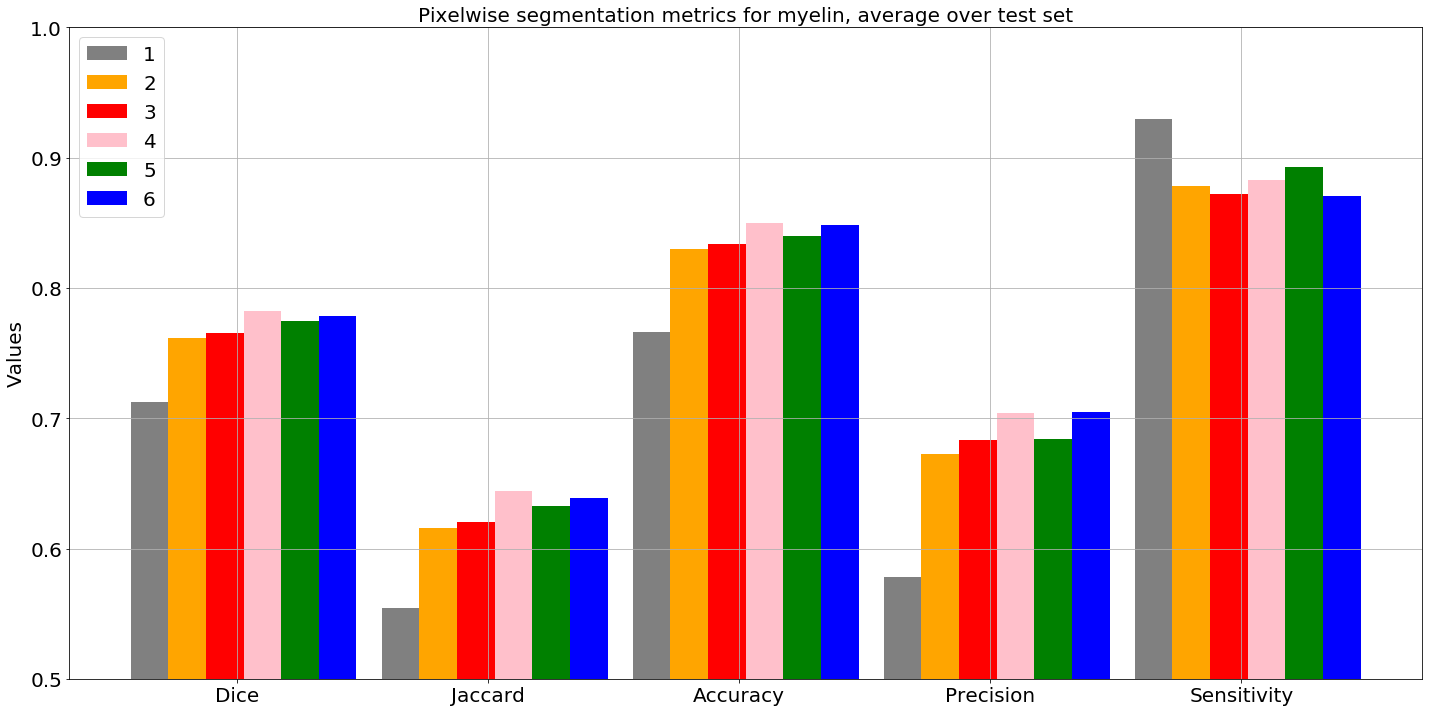

In [153]:
n_groups = 5
width=0.15
fig, ax = plt.subplots(figsize = (20, 10))
index = np.arange(n_groups)

for i in np.arange(1, 7, 1):
    plot = np.arange(-0.5, 1.8, width)
    color = "C" + str(i)
    color = ['black','grey', 'orange', 'red', 'pink', 'green', 'blue']
    rects1 = plt.bar(index + plot[i], score_global[i], width=width, color=color[i],label=i)
    
plt.ylabel('Values',fontsize=20)
plt.title('Pixelwise segmentation metrics for myelin, average over test set',fontsize=20)
plt.xticks(index, ('Dice', 'Jaccard', 'Accuracy', 'Precision', 'Sensitivity'),fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best',fontsize=20)
plt.grid(True)
plt.ylim(0.5, 1)

plt.tight_layout()
plt.show()

In [154]:
score_relative = score_global
score_relative = np.delete(score_relative, 0, 0)
score_relative

array([[0.71261297, 0.55403044, 0.76637077, 0.57834504, 0.92973128],
       [0.76137933, 0.615722  , 0.82957911, 0.67291376, 0.87833043],
       [0.76511158, 0.62060891, 0.83383369, 0.68365051, 0.87222345],
       [0.78232244, 0.64404572, 0.84998584, 0.70419991, 0.88311816],
       [0.77432566, 0.63299877, 0.84009719, 0.6842221 , 0.89277186],
       [0.77864879, 0.63888449, 0.84843183, 0.70484084, 0.87095439]])

In [155]:
diff = np.zeros((5, 5))
print(diff)
for j in range(0, 5):
    for i in range(0, 5):
        #print(i, j)
        diff[i, j] = score_relative[i+1, j] - score_relative[i, j] 
        #print(diff) 


[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [189]:
[ 0.04341854,  0.05589647,  0.04752064,  0.06472552, -0.00214759],
       [-0.00809477, -0.01077759, -0.00278568,  0.00379237, -0.02727857],
       [ 0.01028248,  0.01368501,  0.00328088, -0.00328288,  0.03305823],
       [ 0.00887583,  0.01187675,  0.01197314,  0.02301772, -0.01562149],
       [-0.00254507, -0.0028101 ,  0.00095224,  0.00452597, -0.0133099 ]

array([[ 0.04876636,  0.06169156,  0.06320834,  0.09456872, -0.05140084],
       [ 0.00373225,  0.00488691,  0.00425458,  0.01073675, -0.00610699],
       [ 0.01721086,  0.02343681,  0.01615214,  0.02054941,  0.01089472],
       [-0.00799677, -0.01104695, -0.00988865, -0.01997782,  0.0096537 ],
       [ 0.00432313,  0.00588571,  0.00833464,  0.02061874, -0.02181747]])

In [193]:
relative_dice_random = diff[:, 0]
print(relative_dice_random)
relative_dice_uncert = np.array([0.04341854,-0.00809477,0.01028248,  0.00887583,-0.00254507,])
print(relative_dice_uncert)

relative_dice_stack = np.vstack((relative_dice_random, relative_dice_uncert))
relative_dice_stack


[ 0.04876636  0.00373225  0.01721086 -0.00799677  0.00432313]
[ 0.04341854 -0.00809477  0.01028248  0.00887583 -0.00254507]


array([[ 0.04876636,  0.00373225,  0.01721086, -0.00799677,  0.00432313],
       [ 0.04341854, -0.00809477,  0.01028248,  0.00887583, -0.00254507]])

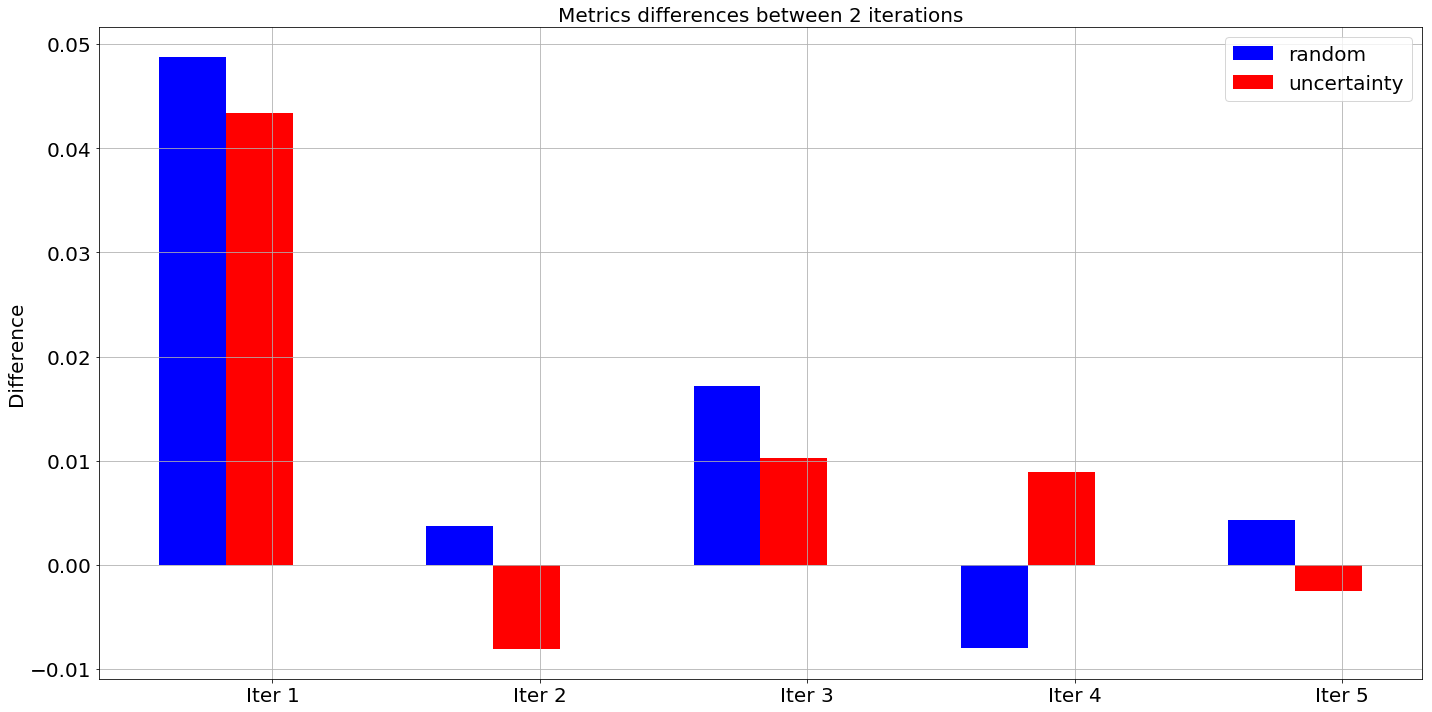

In [207]:
n_groups = 5
width=0.25
fig, ax = plt.subplots(figsize = (20, 10))
index = np.arange(n_groups)

for i in np.arange(0, 2):
    plot = np.arange(-0.3, 1, width)
    color = "C" + str(i)
    color = [ 'blue', 'red']
    label = ["random", "uncertainty"]
    rect1 = plt.bar(index + plot[i], relative_dice_stack[i, :], width=width, color=color[i], label=label[i])
    
plt.ylabel('Difference',fontsize=20)
plt.title('Metrics differences between 2 iterations',fontsize=20)
plt.xticks(index, ('Iter 1', 'Iter 2', 'Iter 3', 'Iter 4', 'Iter 5'),fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best',fontsize=20)
plt.grid(True)
#plt.ylim(-0.04, 0.1)

plt.tight_layout()
plt.show()

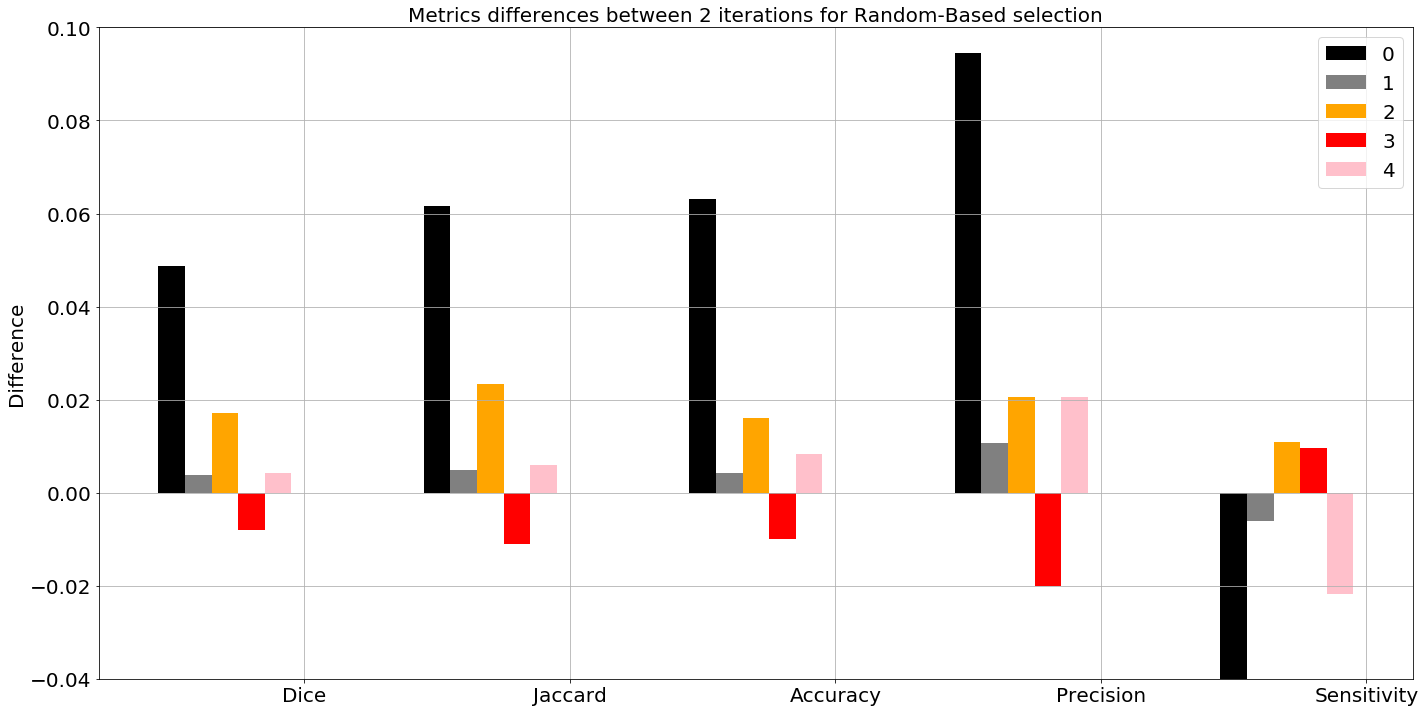

In [159]:
n_groups = 5
width=0.1
fig, ax = plt.subplots(figsize = (20, 10))
index = np.arange(n_groups)

for i in np.arange(0, 5):

    plot = np.arange(-0.5, 1.8, width)
    color = "C" + str(i)
    color = ['black','grey', 'orange', 'red', 'pink', 'blue']

    rects1 = plt.bar(index + plot[i], diff[i, :], width=width, color=color[i], label=i)
    
plt.ylabel('Difference',fontsize=20)
plt.title('Metrics differences between 2 iterations for Random selection',fontsize=20)
plt.xticks(index, ('Dice', 'Jaccard', 'Accuracy', 'Precision', 'Sensitivity'),fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best',fontsize=20)
plt.grid(True)
plt.ylim(-0.04, 0.1)

plt.tight_layout()
plt.show()

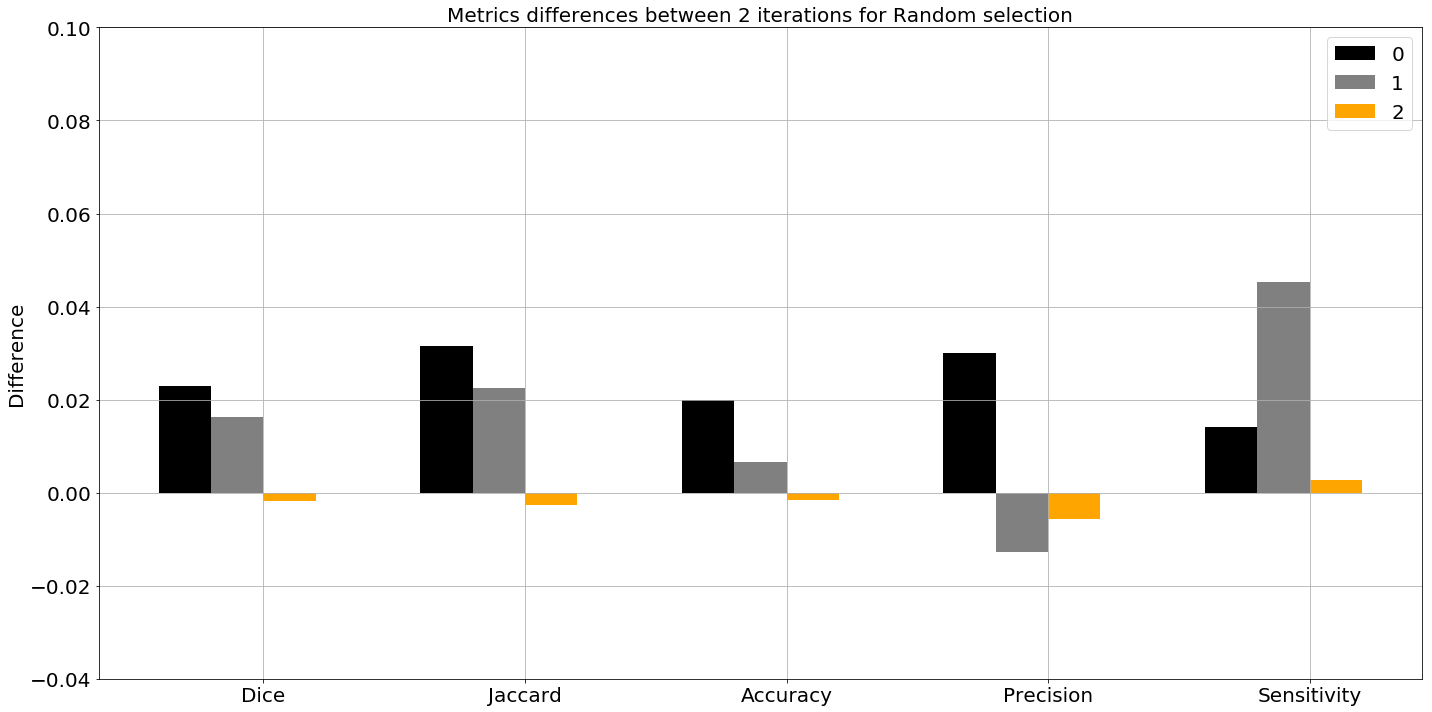

In [124]:
n_groups = 5
width=0.2
fig, ax = plt.subplots(figsize = (20, 10))
index = np.arange(n_groups)

for i in np.arange(0, 3):

    plot = np.arange(-0.3, 1.6, width)
    color = "C" + str(i)
    color = ['black','grey', 'orange', 'red', 'pink']

    rects1 = plt.bar(index + plot[i], diff[i, :], width=width, color=color[i], label=i)
    

plt.ylabel('Difference',fontsize=20)
plt.title('Metrics differences between 2 iterations for Random selection',fontsize=20)
plt.xticks(index, ('Dice', 'Jaccard', 'Accuracy', 'Precision', 'Sensitivity'),fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best',fontsize=20)
plt.grid(True)
plt.ylim(-0.04, 0.1)

plt.tight_layout()
plt.show()

In [34]:
def read_history(history_path):
    txt_file = open(history_path,'r')
    text = txt_file.read()[2:-1].split(", '")

    loss = np.fromstring(text[0].split("[")[1][:-1], sep=',')
    val_dice_coef = np.fromstring(text[1].split("[")[1][:-1], sep=',')
    val_loss = np.fromstring(text[2].split("[")[1][:-1], sep=',')
    dice_coef = np.fromstring(text[3].split("[")[1][:-1], sep=',')
    return loss, val_dice_coef, val_loss, dice_coef


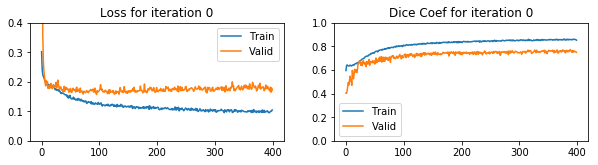

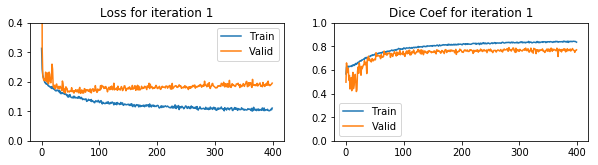

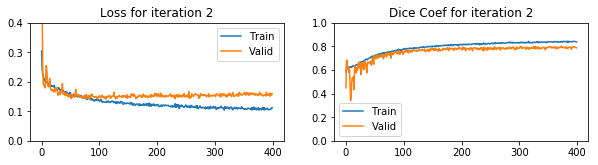

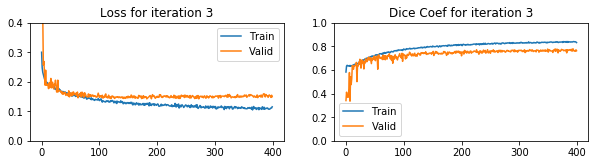

In [35]:
for i  in range(4):
    history_path = ['/home/malub_local/history/1004_1104_28_history_iter_0_.txt', 
                    "/home/malub_local/history/1004_1104_28_history_iter_1_.txt", 
                    "/home/malub_local/history/1004_1104_28_history_iter_2_.txt",
                   "/home/malub_local/history/1004_1104_28_history_iter_3_.txt"] 
    loss, val_dice_coef, val_loss, dice_coef = read_history(history_path[i])
    fig, ax = plt.subplots(figsize = (10, 10))
    plt.subplot(420 + 2*i + 1)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title("Loss for iteration " + str(i))
    plt.legend(["Train", "Valid"])
    plt.ylim(0, 0.4)
    plt.subplot(420 + 2*i + 2)
    plt.plot(dice_coef)
    plt.plot(val_dice_coef)
    plt.title("Dice Coef for iteration " + str(i))
    plt.legend(["Train", "Valid"])
    plt.ylim(0, 1)
    plt.show()

## Display segmentation for X_test 

In [157]:
threshold = 0.4
uncertain_test, uncertain_map_test, predictions_test = uncertainty_for_ranking(model, X_test)

Computing predictions for unlabelled data ...



In [160]:
predictions_test = np.asarray(predictions_test)
predictions_test.shape

(16, 512, 512)

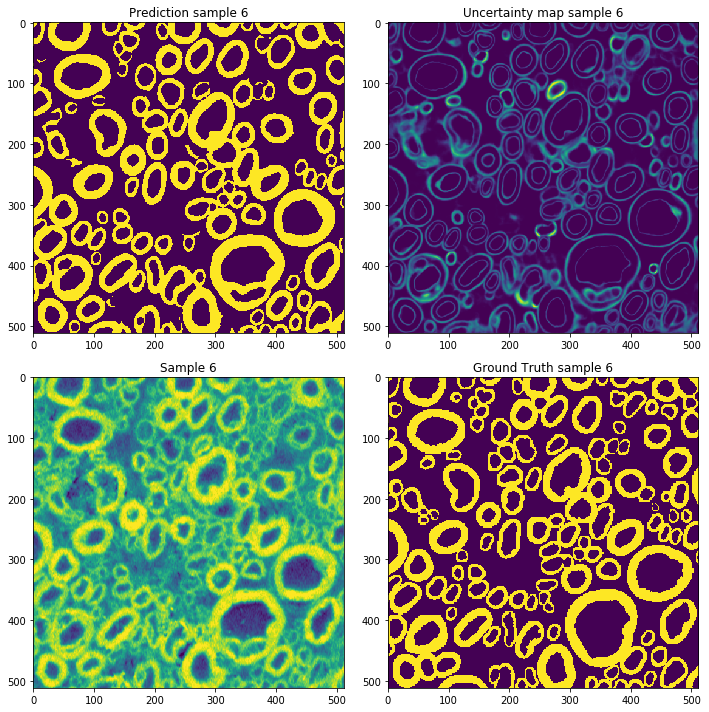

In [185]:
# Plot predictions and uncertainty map for 2 samples 
rand_int = random.randint(0, len(X_test)-1)

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(predictions_test[rand_int][:,:])
plt.title("Prediction sample " + str(rand_int))
plt.subplot(222)
plt.imshow(uncertain_map_test[rand_int])
plt.title("Uncertainty map sample "+ str(rand_int))
plt.subplot(223)
plt.imshow(X_test[rand_int][0,:,:])
plt.title("Sample "+ str(rand_int))
plt.subplot(224)
plt.imshow(y_test[rand_int][0,:,:])
plt.title("Ground Truth sample "+ str(rand_int))
plt.tight_layout()
plt.show()


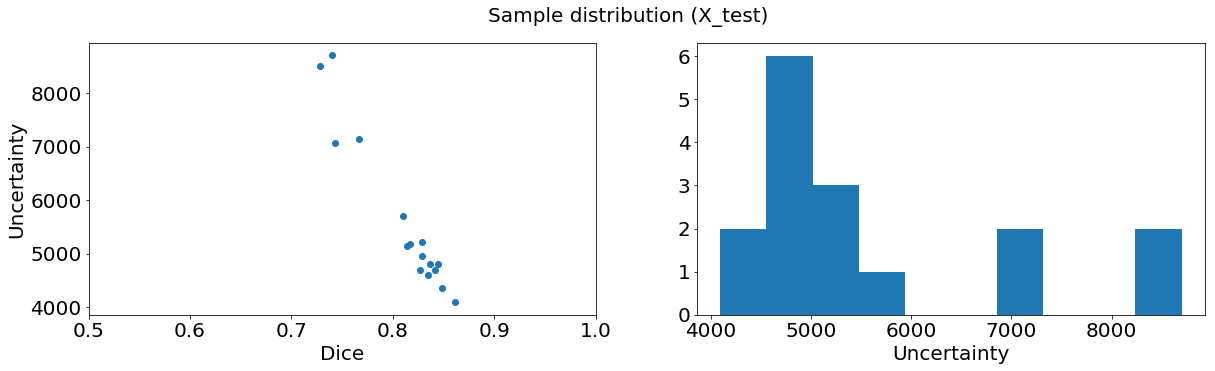

In [165]:
dice_plot = np.zeros(len(X_test))


for i in range(len(X_test)):
    dice_plot[i] = compute_dice_coef(y_test[i][0,:,:], predictions_test[i][:,:])
    

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.scatter(dice_plot, uncertain_test)
plt.xlabel("Dice", fontsize=20)
plt.ylabel("Uncertainty", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0.5, 1)

plt.subplot(122)
plt.hist(uncertain_test.flatten(), 10)
plt.xlabel("Uncertainty", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.suptitle("Sample distribution (X_test)", fontsize=20)
plt.show()

## Choose threshold 

In [36]:
# uncertainty computation
dice_coef_test = np.zeros(len(X_test))
dice = []

print("Computing log predictions ...\n")
predictions = predict(X_test, model)

for threshold in np.arange(0, 1, 0.05):
    dice_coef_test = np.zeros(len(X_test))
    for i in range(len(X_test)):
        sample = X_test[i].reshape([1, 1, img_rows, img_cols])
        sample_prediction = cv2.threshold(predictions[i], threshold, 1, cv2.THRESH_BINARY)[1].astype('uint8')
        dice_coef_test[i] = compute_dice_coef(y_test[i][0], sample_prediction)
    dice.append(np.mean(dice_coef_test))


print(len(dice))
print("Done")


Computing log predictions ...

20
Done


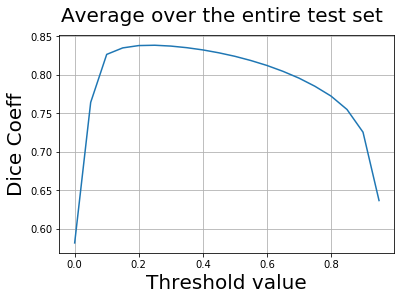

In [37]:
plt.plot(np.arange(0, 1, 0.05), dice )
plt.suptitle("Average over the entire test set", fontsize = 20)
plt.ylabel("Dice Coeff", fontsize = 20)
plt.xlabel("Threshold value", fontsize = 20)
plt.grid()
#plt.ylim(0.7, 0.75)
plt.show()

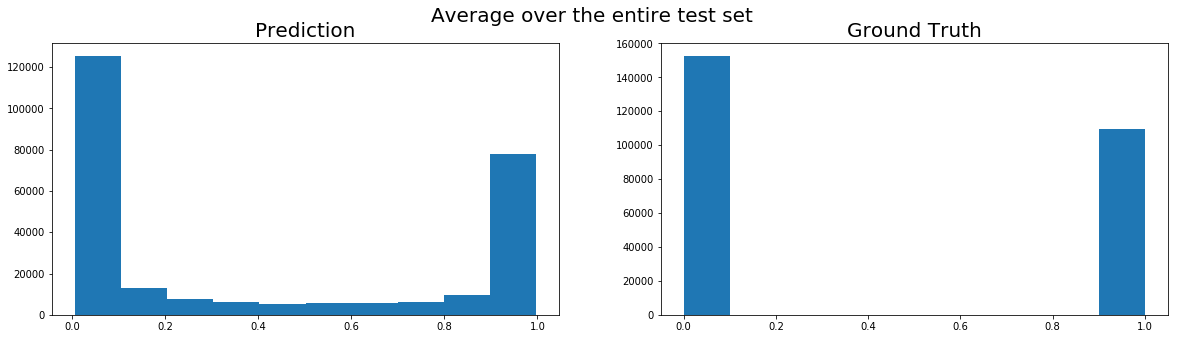

In [38]:
plt.figure(figsize=(20,5))
plt.suptitle("Average over the entire test set", fontsize = 20)
plt.subplot(121)
plt.hist(predictions[0].flatten())
plt.title("Prediction", fontsize = 20)
plt.subplot(122)
plt.hist(y_test[0].flatten())
plt.title("Ground Truth", fontsize = 20)
plt.show()

# Visuaize Data Augmentation

In [ ]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

def visualize_data_augmentation(generator):
    batch1 = take(1, generator)
    max_images = 16
    grid_width = 8
    grid_height = 1
    fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
    for i in range(8):
        img = batch1[0][0][i, 0, :, :]
        mask = batch1[0][1][i, 0, :, :]
        ax = axs[ i % grid_width]
        ax.imshow(img, cmap="gray")
        ax.set_yticklabels([])
        ax.set_xticklabels([])


    fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 10))
    for i in range(8):
        img = batch1[0][0][i, 0, :, :]
        mask = batch1[0][1][i, 0, :, :]
        ax = axs[ i % grid_width]
        ax.imshow(mask, cmap="gray")
        ax.set_yticklabels([])
        ax.set_xticklabels([])

In [ ]:
visualize_data_augmentation(train_generator)